## people 模組注意事項目
* people 模組收錄文字探勘基本的工具，包括 篩選文本、斷詞、詞對與語料庫分析、主題分析、文章分群、潛在語意分析、時間趨勢繪圖。
* import people 之後，會出現所有的函數列表，只要複製貼上，即可使用。
* 輸入參數，即可得出結果檔，關次參數的定義，可參考 people.ipynb 檔案，裡面有程式本身與說明。
* 資料檔基本上用 dataframe 格式，裡面有 year, token, tfidf, textrank, doc_content, title, filename 等欄位。
* People 模組執行時會自動儲存結果檔，請大家新增一個資料夾，my python，其下再新增 people 資料夾，接著 data, plot 兩個資料夾，主要是為了放置資料檔與圖像檔。



# 與 google drive 連線

In [ ]:
# import os
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# # 列印 people 下面的檔案檢查
# path="/content/drive/MyDrive/colab/people/"
# pth="/content/drive/my python/colab/people/"
# os.chdir(path)
# dir_list = os.listdir(path) 
# print (dir_list)

['ipynb', 'pic', '基本資訊', 'data', 'corpus', 'plot', 'jieba', 'xlsx', 'xml', '__pycache__', 'p4_token.ipynb', 'people.py', 'people.ipynb', 'p5_data_select.ipynb', 'TaipeiSansTCBeta-Regular.ttf', 'p6_人民日報基本資訊.ipynb']


# import people

In [ ]:
# path="/content/drive/MyDrive/colab/people/"
# pth="/content/drive/MyDrive/my python/people/"
# os.chdir(path)
# import people

In [ ]:
path="d:/my python/people/"
pth="d:/my python/people/"

In [ ]:
import os
os.chdir(path)
import people


    基本概況
        dfi=basic_info(year, path, title,rolling=1)
        df_kw= people.key_word_trend_all_year(year, kw, path, title,rolling=1)   
        df_kt= people.key_word_trend(df, kw, field, time, pth, title,rolling=1)
    資料選取
        (df, df_year)= people.doc_select(year, kw, field, unit, path, title)
        people.print_doc_select_random(df,num,field)
        df_ks=people.select_document_by_key_word(df, field, kw ,num, pth)
        people.plot_doc_select_year(df_year)
        people.print_filename(filename, field, path)
    詞頻與詞對
        df_corpus= people.corpus_map_year(df,kw, corpus,window, pth,title)
        df_corpus= people.read_corpus_map_year(kw,pth)
    情感分析
        df_pn= people.sentiment_analysis(df, field, path, title,rolling=1)
        df_pn= people.read_sentiment_cluster_analysis(pth,title)
    主題分析
        (df_tp, df_topic,df_lsa)= people.topic_model(df,field,num_i=10, method,pth, title)  
        (df_tp, df_topic,df_lsa)= people.read_topic_model(pth, title) 
   

In [ ]:
import numpy as np
import pandas as pd
import random
import pickle
import re
import io
import random
from collections import Counter

In [ ]:
# from __future__ import print_function
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
rcParams["font.sans-serif"] = ["kaiu"] 
rcParams["font.family"] ="DFKai-sb"

In [ ]:
# # 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
# !wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# import matplotlib as mpl
# import matplotlib.pyplot as plt 
# from matplotlib.font_manager import fontManager

# # 改style要在改font之前
# # plt.style.use('seaborn')  

# fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
# mpl.rc('font', family='Taipei Sans TC Beta')

--2022-03-22 06:53:32--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.98.100, 142.250.98.138, 142.250.98.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.98.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nl3212fqpn4lav5c88vko1pqm5ci221m/1647931950000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2022-03-22 06:53:36--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nl3212fqpn4lav5c88vko1pqm5ci221m/1647931950000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|172.217.203.1

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
# 中文設定1: 楷體字
from matplotlib import rcParams
rcParams["font.sans-serif"] = ["kaiu"] 
rcParams["font.family"] ="DFKai-sb"

# @ 人民日報基本統計

In [ ]:
def basic_info(year, path="/content/drive/MyDrive/colab/people/",title='basic_count'):
    years=[]
    count_arti=[]
    count_para=[]
    count_sent=[]
    count_token=[]
    count_word=[]
    for n in range(len(year)):
        fname=str(year[n])+"_jieba.xlsx"
        df=pd.read_excel(path+"jieba/"+fname, 0)
        # 段落的識別
        con=df["doc_content"].str.replace("    ","\n")
        con_list=list(con)  
        token=df["doc_content"]
        token_list=list(con)          
        # 文章數
        count_arti.append(len(con_list))
        c_para=0
        c_sent=0
        c_token=0
        c_word=0
        for t in range(len(con_list)):
            if type(con_list[t])== str:
                # 段落
                obj=re.split('[\n]',con_list[t])  
                c_para+=len(obj)
                # 句子        
                obj=re.split('[？！：。\n]',con_list[t])
                c_sent+=len(obj)            
                # 字詞      
                obj=con_list[t].split()
                c_token+=len(obj)  
                # 字    
                obj=con_list[t].replace(' ','')
                c_word+=len(obj)  
        count_para.append(c_para)     
        count_sent.append(c_sent) 
        count_token.append(c_token) 
        count_word.append(c_word) 
        years.append(year[n])
        print (year[n],"done",end=" ")   
    # dataframe    
    data=list(zip(years,count_arti, count_para, count_sent, count_token, count_word))
    df=pd.DataFrame(data,columns=["year","count_arti", "count_para", "count_sent", "count_token", "count_word"])
    # plot   
    plt.figure(figsize=(20,10))
    df.index=year
    df[["count_arti","count_para"]].plot(figsize=(20,10))
    plt.figure(figsize=(20,10))
    df.index=year
    df[["count_sent","count_token","count_word"]].plot(figsize=(20,10))
    plt.show()

    # save
    title='count_arti_para_sent_token_word'
    if path.startswith('/content'):
        pth="/content/drive/MyDrive/my python/people/"
    else:
        pth= "D:/my python/people/"
    fname=pth+"data/"+title+".xlsx"
    writer = pd.ExcelWriter(fname)
    df.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save() 
    return df  

## show

1946 done 1947 done 1948 done 1949 done 1950 done 1951 done 1952 done 1953 done 1954 done 1955 done 1956 done 1957 done 1958 done 1959 done 1960 done 1961 done 1962 done 1963 done 1964 done 1965 done 1966 done 1967 done 1968 done 1969 done 1970 done 1971 done 1972 done 1973 done 1974 done 1975 done 1976 done 1977 done 1978 done 1979 done 1980 done 1981 done 1982 done 1983 done 1984 done 1985 done 1986 done 1987 done 1988 done 1989 done 1990 done 1991 done 1992 done 1993 done 1994 done 1995 done 1996 done 1997 done 1998 done 1999 done 2000 done 2001 done 2002 done 2003 done 2004 done 2005 done 2006 done 2007 done 2008 done 2009 done 2010 done 2011 done 2012 done 

<Figure size 1440x720 with 0 Axes>

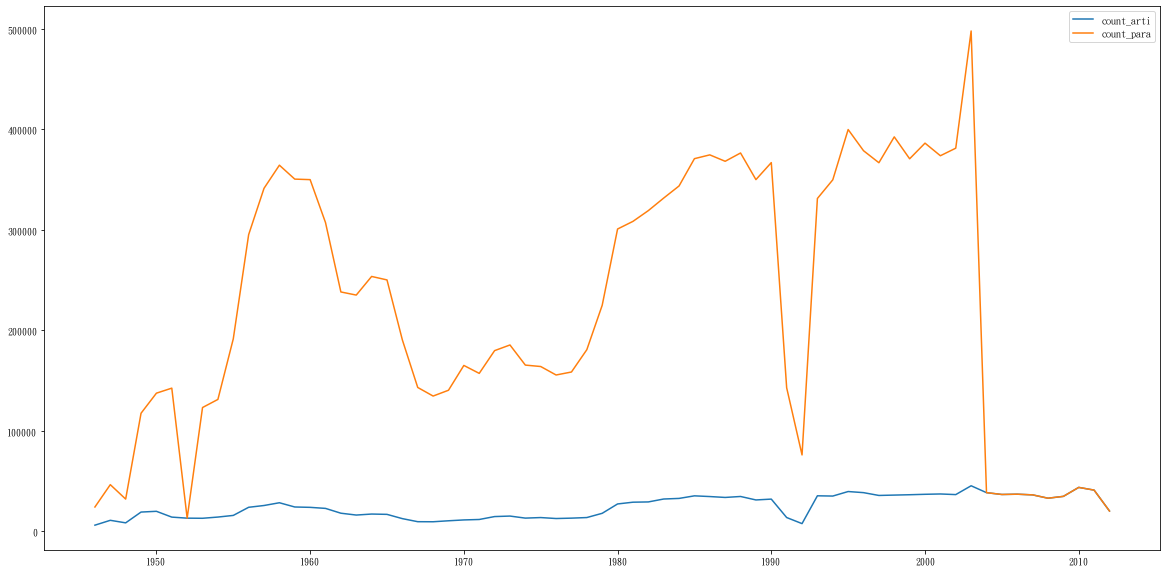

<Figure size 1440x720 with 0 Axes>

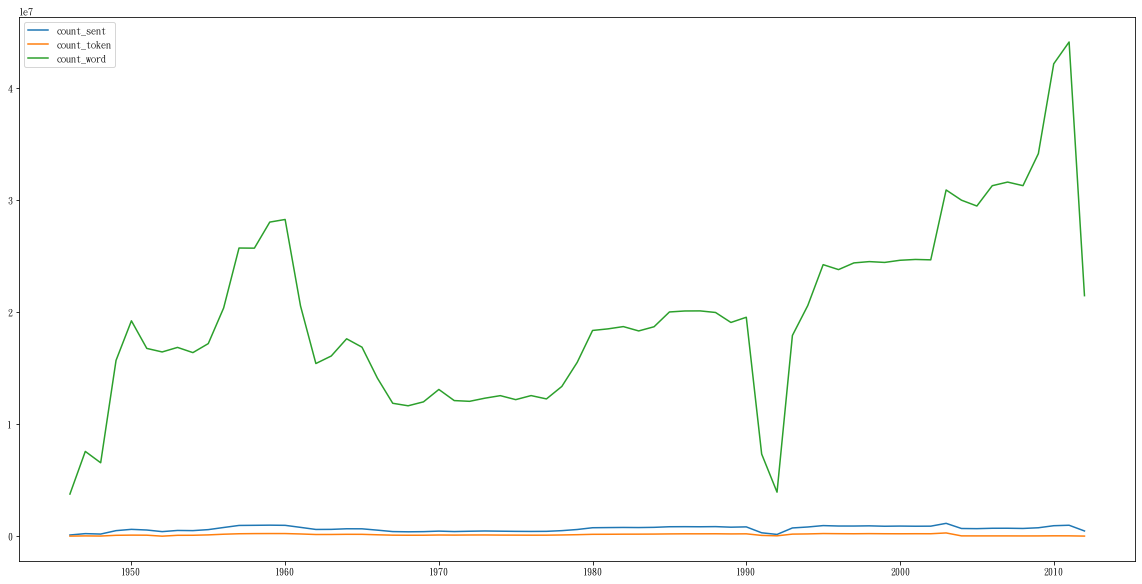

,year,count_arti,count_para,count_sent,count_token,count_word
1946,1946,5937,24028,117260,18909,3769042
1947,1947,10771,46270,239468,36141,7574842
1948,1948,8247,31914,201284,23513,6561304
1949,1949,18988,117401,505899,90476,15696124
1950,1950,19740,137375,621333,106284,19227195
...,...,...,...,...,...,...
2008,2008,32784,32783,701353,32783,31286349
2009,2009,34611,34611,763034,34611,34141974
2010,2010,43550,43550,946278,43550,42156532
2011,2011,40856,40856,987317,40856,44104726


In [ ]:
year=[1946,1947,1948,1949,
      1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,
      1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,
      1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,
      1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,
      1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
      2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
      2010,2011,2012]
title='basic_count'
people.basic_info(year, path, title)

# @ 篩選原始資料


In [ ]:
year=[1946,1947,1948,1949,
      1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,
      1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,
      1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,
      1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,
      1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
      2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
      2010,2011,2012]

In [ ]:
kw=[]   # 空白代表不設
field ="textrank"  
unit ="arti"     
title="all"  
path="d:/my python/people/"

In [ ]:
kw=["斗争","革命","阶级"]
field ="doc_content"  
unit ="sent"     
title="鬥爭"  

In [ ]:
kw=["台湾"]
field ="token"  
unit ="para"     
title="台湾"  

In [ ]:
kw=["邓小平"]
field ="token"  
unit ="para"     
title="邓小平"  

In [ ]:
objects=[]
years=[]
filenames=[]
titles=[]
count=[]
rate=[]
ye=[]
for n in range(len(year)):
    fname=str(year[n])+"_jieba.xlsx"
    df=pd.read_excel(path+"jieba/"+fname, 0)
    con=df[field].str.replace("    ","\n")
    con_list=list(con)  
    num_obj=0
    # 每篇文章逐一檢查
    for t in range(len(con_list)):
        if type(con_list[t])== str:
            # 分析單元：文章，段落，句子，前後字詞
            # 如果 field 是 tfidf or textrank, 改為 arti
            if field in ["tfidf","textrank"]:
                unit="arti"
                obj=[con_list[t]]
                num_obj=len(obj)
            if unit=="para":
                # 如果是段落
                obj=re.split('[\n]',con_list[t])   
                num_obj+=len(obj)  
            elif unit=="sent":
                # 如果是句子        
                obj=re.split('[？！：。\n]',con_list[t])
                num_obj+=len(obj) 
            elif unit=="arti":    
                # 以文章為單位
                obj=[con_list[t]]
                num_obj+=len(obj) 
            # 每一個單元，再進行關鍵字篩選
            if len(obj)>0:
                for s in obj:                  
                    # 有關鍵字組
                    if len(kw)>0:
                        for k in kw:
                            # 有找到方列入，含其他資訊
                            if s.find(k)>0:          
                                objects.append(s)
                                years.append(year[n])
                                titles.append(df.title[t])
                                filenames.append(df.filename[t])                            
                                break  
                    # 無關鍵字組            
                    else:
                        objects.append(s)
                        years.append(year[n])
                        titles.append(df.title[t])
                        filenames.append(df.filename[t])   
           
    # 以年為單位，累計次數 
    count.append(len(objects))
    rate.append(len(objects)/num_obj)
    ye.append(year[n]) 
    print (year[n],"done",len(objects),num_obj,len(objects)/num_obj)

if unit =="arti":
    data=list(zip(years,filenames, titles, objects))
    df=pd.DataFrame(data,columns=["year","filename","title",field])
    # 合併至年，累計該年數目
    data=list(zip(ye,count, count))
    df_year=pd.DataFrame(data,columns=["year","count","rate"])   
else:    
    data=list(zip(years,filenames, titles, objects))
    df=pd.DataFrame(data,columns=["year","filename","title",field])
    # 合併至年，累計該年數目與比例
    data=list(zip(ye,count, rate))
    df_year=pd.DataFrame(data,columns=["year","count","rate"])     

# save，必須要有 data 次目錄     
if path.startswith('/content'):
    pth="/content/drive/MyDrive/my python/people/"
else:
    pth= "D:/my python/people/"
    
fname=pth+"data/"+unit+"_"+field+"_"+title+"_year"+".xlsx"
writer = pd.ExcelWriter(fname)
df_year.to_excel(writer,'Sheet1',encoding='utf-8')
writer.save()        

try:    # 先存 excel
    fname=pth+"data/"+unit+"_"+field+"_"+title+".xlsx"
    writer = pd.ExcelWriter(fname)
    df.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save()
except:   # error 再存 pickle
    fname=pth+"data/"+unit+"_"+field+"_"+title+".pkl"
    with open(fname, "wb") as fp: 
        pickle.dump(df, fp)      

1946 done 5929 2 2964.5
1947 done 16692 2 8346.0
1948 done 24938 2 12469.0
1949 done 43830 2 21915.0
1950 done 63502 2 31751.0
1951 done 77428 2 38714.0
1952 done 90277 2 45138.5
1953 done 103006 2 51503.0
1954 done 116901 2 58450.5
1955 done 132430 2 66215.0
1956 done 155752 2 77876.0
1957 done 180776 2 90388.0
1958 done 208353 2 104176.5
1959 done 231645 2 115822.5
1960 done 254620 2 127310.0
1961 done 276184 2 138092.0
1962 done 293294 2 146647.0
1963 done 308711 2 154355.5
1964 done 325051 2 162525.5
1965 done 340999 2 170499.5
1966 done 352941 2 176470.5
1967 done 362039 2 181019.5
1968 done 371083 2 185541.5
1969 done 380988 2 190494.0
1970 done 391827 2 195913.5
1971 done 403108 2 201554.0
1972 done 417222 2 208611.0
1973 done 431816 2 215908.0
1974 done 444433 2 222216.5
1975 done 457560 2 228780.0
1976 done 469614 2 234807.0
1977 done 482216 2 241108.0
1978 done 495458 2 247729.0
1979 done 512752 2 256376.0
1980 done 538872 2 269436.0
1981 done 566668 2 283334.0
1982 done 5946

In [ ]:
df_year

,year,count,rate
0,1946,5929,5929
1,1947,16692,16692
2,1948,24938,24938
3,1949,43830,43830
4,1950,63502,63502
...,...,...,...
62,2008,1447980,1447980
63,2009,1482563,1482563
64,2010,1526045,1526045
65,2011,1566689,1566689


## read_file(filename, pth)

In [ ]:
def read_file(filename, pth):
    fname=pth+filename
    if filename.endswith('.csv'):
        df=pd.read_csv(fname, 0)        
    elif filename.endswith('.xlsx'):
        df=pd.read_excel(fname, 0)    
    elif filename.endswith('.pkl'):
        df=pd.read_pickle(fname)           
    return df

In [ ]:
filename='data/sent_doc_content_鬥爭.pkl'
pth='D:/my python/people/'
df=people.read_file(filename,pth)
df

,year,filename,title,doc_content
0,1946,人民日報_19460515_2_1945,人民日报发刊志祝,真正人民的报纸不仅是人民的喉舌，还应是人民的司机和人民事业的组织者；在当前更应成为边区人民反...
1,1946,人民日報_19460515_3_1959,英勇的四平街保卫战,民主与反民主的斗争，光明的前途，是在这重要的时间内发展着
2,1946,人民日報_19460515_3_1958,消息报记者报导法国宪草复决失败原因,我们相信，使反动势力获得暂时胜利的，决不会在新民主主义者行列中打起紊乱，可是，这件事又一次加...
3,1946,人民日報_19460515_3_1955,日共力主联合内阁片山组阁搁浅,社会党内部已展开激烈的斗争
4,1946,人民日報_19460515_1_4256,发刊词,日寇投降以后，在肃清敌伪，制止内战，争取和平的五个月的斗争中，晋冀鲁豫的人民、八路军、共产党...
...,...,...,...,...
1699346,2012,人民日報_20120103_2_20570,肝胆相照创伟业 凝心聚力谱华章,历史长河浩浩汤汤，由辛亥首义“黄鹤楼头兮忽树革命旗”起始，历经波澜起伏的一百年，古老中国有如...
1699347,2012,人民日報_20120102_2_20598,在全国政协新年茶话会上的讲话,我们要坚持以执政能力建设和先进性建设为主线，全面推进党的建设新的伟大工程，着力加强领导班子和...
1699348,2012,人民日報_20120101_1_20621,胡锦涛致电祝贺金正恩担任朝鲜人民军最高司令官,决议指出，朝鲜军队和人民决心遵循金正日的遗训，在金正恩的领导下把社会主义强盛国家建设事业和主...
1699349,2012,人民日報_20120101_3_20648,朝鲜发布迎接金日成诞辰100周年联合口号,口号号召全党、全军和全民在金正恩领导下，千方百计地加强国家政治军事威力，使革命大高潮的烈火更...


## 隨機閱讀文本

In [ ]:
num=5
field='doc_content'
df_sample=df.sample(num)
for n in range(len(df_sample)):
    print(df_sample.filename.iloc[n])
    # print (df_sample.title.iloc[n])
    obj=re.split('[？！：。\n]',df_sample[field].iloc[n])
    for o in obj:
          if len(o)>0:
              print (o)
    print ("---------------------------")

人民日報_19560207_1_136149
农业合作化运动是一场激烈的阶级斗争，反革命分子和其他各种犯罪分子必然会而且事实上也正在进行各种破坏活动
---------------------------
人民日報_19720613_4_421095
在江水英和李志田进行面对面的交锋中，又通过李志田对她进行的“只知一个劲儿丢、丢、丢，却不管社员愁、愁、愁”和三个“对得起”的指责，把矛盾推向顶峰，然后引出江水英的一大套回肠荡气的唱段，让江水英对他的错误思想进行细致分析和严肃批评；在弄通思想以后，又通过阶级敌人这个活生生的反面教员，使李志田进一步认识了错误思想的危害
---------------------------
人民日報_19690603_4_386569
用大队艰苦奋斗的历史和美好的前景，教育知识青年要做无产阶级革命事业的可靠接班人
---------------------------
人民日報_19680802_6_378435
毛主席关于人民战争的光辉思想是正在为民族解放而斗争的巴勒斯坦人民手中最强大的武器
---------------------------
人民日報_19541011_4_115583
公告最后号召河内全体居民，不分职业、宗教信仰和政治派别，加紧团结在胡志明主席和政府的周围，参加保卫和建设首都的各项活动，并对全国人民的保卫和巩固和平，在全国范围内实现统一、独立和民主的斗争作出贡献
---------------------------


## 指定閱讀某個文本

In [ ]:
filename='人民日報_19720109_3_415526'
field=['filename','title','doc_content','token','textrank']
year=filename[5:9]
fname=str(year)+"_jieba.xlsx"
temp=pd.read_excel(path+"jieba/"+fname, 0) 
content=temp[temp.filename==filename][field]     
for col in field:
      print (col,"---")
      print (list(content[col])[0])

filename ---
人民日報_19720109_3_415526
title ---
坏事变好事要有一定的条件
doc_content ---





王汝恒程福仪
在尖锐复杂的两个阶级、两条道路、两条路线斗争中，我们粉碎了刘少奇一类骗子妄图篡党篡政，改变党的路线和政策，复辟资本主义的罪恶阴谋。在毛主席的英明领导下，经过全党、全军和全国人民的揭露、批判和斗争，取得伟大的胜利，进一步巩固了无产阶级专政，把坏事变成了好事。
坏事是可以变成好事的。然而，有的同志却看不到坏事变好事必须要有一定的条件，以为坏事可以自然地变好事。这种看法是错误的。毛主席教导说：“在一定的条件下，坏的东西可以引出好的结果，好的东西也可以引出坏的结果。”这就清楚地告诉我们：坏事和好事是一对矛盾的两个侧面，它们可以各自向对立面所处的地位转化。好事会变成坏事，坏事也能变成好事。“在这里，条件是重要的。没有一定的条件，斗争着的双方都不会转化。”我们常说，“锄掉毒草可以肥田”。毒草是怎么肥田的呢？这是由于人们锄倒了毒草。假如没有人去锄，毒草照样还是毒草，它就不会自然地变成肥料。我们还常说，“吃一堑长一智”。这个“智”是怎么“长”的呢？这是因为人们认真总结经验，找出自己为什么“吃一堑”的原因，从失败中取得教训，改正自己的错误思想，以免今后再“吃”这样一“堑”。倘若没有这些主观努力，“吃一堑”之后就不会自然而然地收到“长一智”的效果。同样，五十年以来，我们党经历了多次重大的路线斗争，粉碎了机会主义路线头子妄图分裂党、篡改党的性质、取消党的领导的罪恶阴谋。每一次揭露和战胜了错误路线，我们党就前进，就胜利，促进了革命事业的发展。事实雄辩地说明，坏事绝不会自然地变成好事，它必须要有人的主观努力作为条件。那种认为坏事可以自然地变好事的想法，只是一种主观愿望，是不符合客观事物发展规律的。
为什么我们有的同志还会产生这种“自然转化”的思想呢？就其方法论上来讲，如毛主席所批评的，是由于这些同志看问题的方法不对。他们用资产阶级的观点去看问题，犯了唯心论和形而上学的错误。从政治上说，这些同志缺乏高度的路线斗争和继续革命的觉悟。他们不是想到怎样在坏事面前认真总结经验，提高自己的路线斗争觉悟，掌握阶级斗争的规律，更加自觉地执行毛主席的革命路线。而是受了刘少奇一类骗子散布的“阶级斗争熄灭论”的影响，认识不到社会主义这一历史阶

# 讀檔

## 隨機選取5000

In [ ]:
# 為節省時間，隨機選取 5000
df=df.sample(5000)
df=df.sort_index(axis = 0)
df.index=range(len(df))
len(df)

5000

## 讀檔，隨機選取 10000 筆

In [ ]:
# 範例
filename='data/arti_textrank_all.pkl'
pth="d:/my python/people/"
df=people.read_file(filename,pth)
df=df.sample(10000)
df=df.sort_index(axis = 0)
df.index=range(len(df))

In [ ]:
# 範例
filename='data/para_token_台灣.xlsx'
pth="d:/my python/people/"
df=people.read_file(filename,pth)
df=df.sample(10000)
df=df.sort_index(axis = 0)
df.index=range(len(df))

# @ 關鍵字趨勢變化

In [ ]:
year=[1946,1947,1948,1949,
      1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,
      1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,
      1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,
      1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,
      1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
      2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
      2010,2011,2012]     
title='basic_count'
kw=[["斗争","革命","阶级"],["制度","建設","現代","科學"]]
title=''

In [ ]:
def key_word_trend_all_year(year, kw, path, title,rolling=1):
    # 空白的dataframe
    df_kw=pd.DataFrame()
    # 逐篇文章計算  
    for n in range(len(year)):
        # 讀取 xlsx 成為 dataframe
        path2= path+ 'jieba/'
        fname=str(year[n])+"_jieba.xlsx"
        df=pd.read_excel(path2+fname, 0)   
        # 選擇欄位 doc_content
        content=list(df.doc_content)
        # 年月
        era_list=list(df.era.unique())
        era_list=sorted(era_list)
        count_y=[]
        ym=[]
        for m in range(len(era_list)):
            df_ym=df[df['era']==era_list[m]]
            # 各月資料
            count_m=[era_list[m]]
            # 關鍵字組
            for k in kw:
                num=0
                total=0
                # 單一關鍵字
                for j in k:
                    num+=sum(df_ym.doc_content.str.count(j))  
                    total+=sum(df_ym.doc_content.str.len())
                rate=num/total           
                count_m.append(num)
                count_m.append(rate)
            count_y.append(count_m)          
        # 垂直合併    
        df0=pd.DataFrame(count_y)
        df_kw=df_kw.append(df0)  
        # 計數
        print (year[n], end=",")

    # 繪圖
    df_kw['date'] = pd.to_datetime(df_kw[0], format="%Y%m")
    df_kw.set_index('date', inplace=True)
    # 圖面大小
    plt.figure(figsize=(16,9))
    for k in range(2,len(df_kw.columns),2):
        plt.plot(df_kw[k].rolling(rolling).mean(),label=",".join(kw[int(k/2-1)]))
    # 圖例
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
    plt.show()
    return df_kw

## show

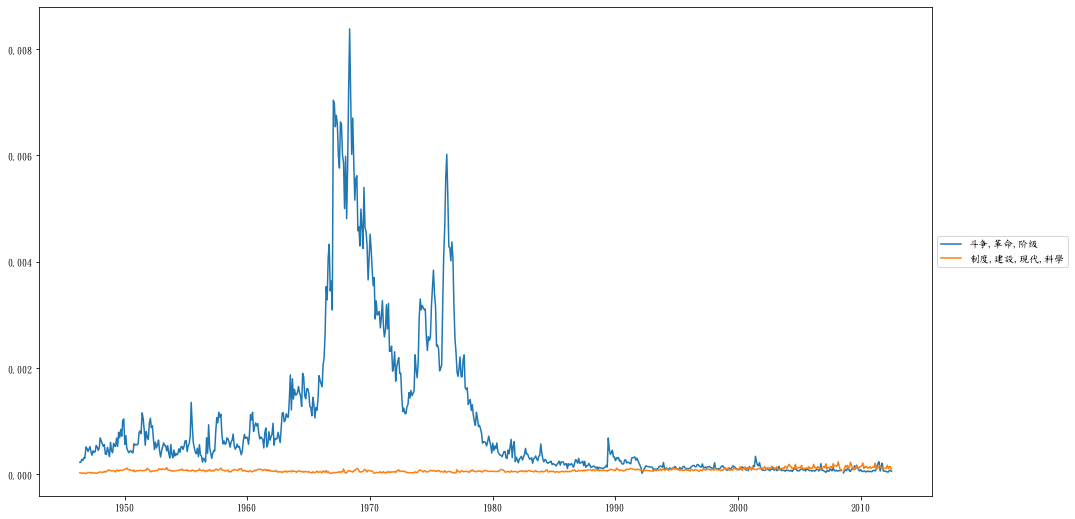

In [ ]:
year=[1946,1947,1948,1949,
      1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,
      1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,
      1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,
      1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,
      1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
      2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
      2010,2011,2012]   
title='basic_count'
kw=[["斗争","革命","阶级"],["制度","建設","現代","科學"]]
df_kw=key_word_trend_all_year(year, kw, path, title,rolling=1)

In [ ]:
df1=df_kw[df_kw[0]>199001]

C:\Users\User\AppData\Local\Temp/ipykernel_15940/4201857423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kw['date'] = pd.to_datetime(df_kw[0], format="%Y%m")


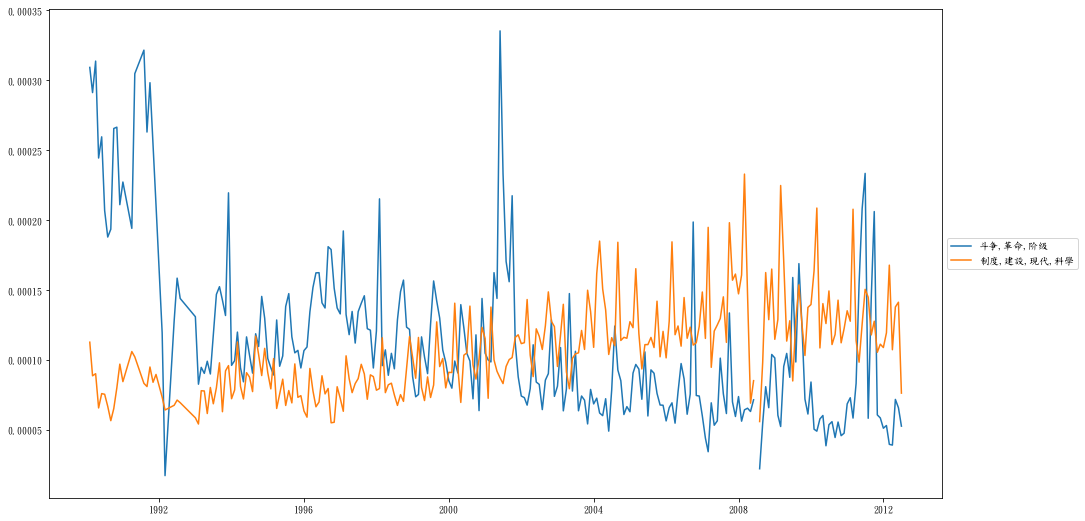

In [ ]:
# 繪圖，記得我們已先設定了字型
df1['date'] = pd.to_datetime(df1[0], format="%Y%m")
df1.set_index('date', inplace=True)
# 圖面大小
plt.figure(figsize=(16,9))
for k in range(2,len(df1.columns),2):
    plt.plot(df1[k].rolling(rolling).mean(),label=",".join(kw[int(k/2-1)]))
# 圖例
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
plt.show()

1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,

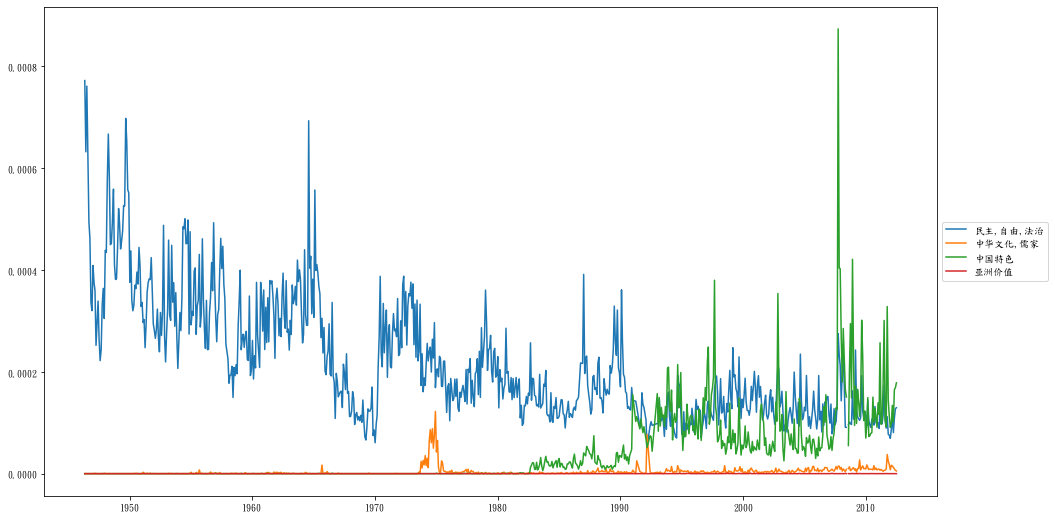

In [ ]:
kw=[['民主','自由','法治'],['中华文化','儒家'],['中国特色'],['亚洲价值']]
title=''
time='year'
field='textrank'
df_kw=key_word_trend_all_year(year, kw, path, title,rolling=1)

1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,

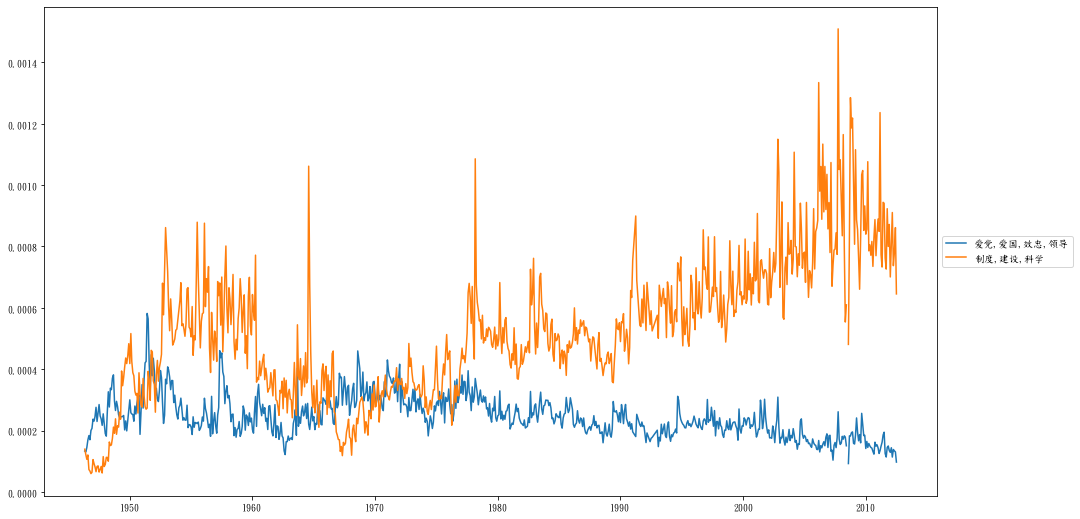

In [ ]:
kw=[["爱党","爱国","效忠","领导"],["制度","建设","科学"]]
title=''
time='year'
field='textrank'
df_kw=key_word_trend_all_year(year, kw, path, title,rolling=1)

# @ 情感分析

## show

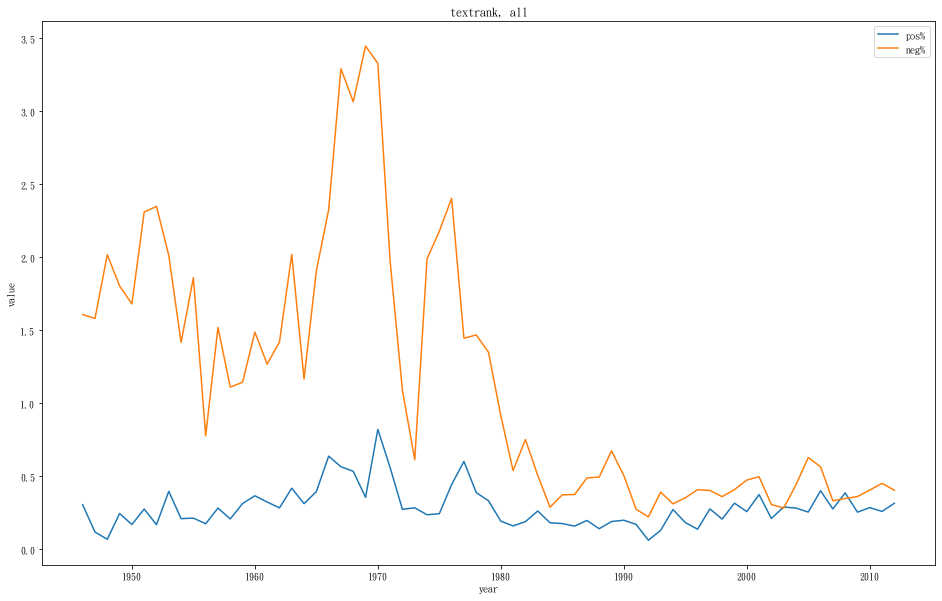

In [ ]:
field='textrank'
title='textrank, all'
rolling=5
df_pn= people.sentiment_analysis(df, field, path, title,rolling=1)

In [ ]:
df_pn

,year,褒獎詞,貶抑詞,反革命,count,pos,neg,anti,pos%,neg%
0,1946,"[(英雄, 2), (合法, 3), (贡献, 2), (光辉, 1), (百战百胜, 1)...","[(破坏, 2), (敌伪, 4), (谣言, 1), (捏造, 1), (威胁, 4), ...","[(帝国主义, 2), (反动派, 7), (国民党, 9), (反动, 1), (卖国, ...",33,10,53,32,0.303030,1.606061
1,1947,"[(勇敢, 3), (英雄, 2), (精力, 1), (卓越, 1), (创造性, 1)]","[(血腥, 1), (强迫, 8), (杀害, 2), (破坏, 6), (破产, 2), ...","[(富农, 3), (地主, 16), (贪污, 1), (剥削, 6), (封建, 6),...",69,8,109,80,0.115942,1.579710
2,1948,"[(创造性, 1), (优良传统, 1), (历史教训, 1), (充分发挥, 1)]","[(垄断, 1), (威胁, 3), (出卖, 4), (落后, 2), (错误, 11),...","[(经验主义, 1), (坏分子, 3), (流氓, 3), (资本家, 1), (恐怖主义...",60,4,121,93,0.066667,2.016667
3,1949,"[(百战百胜, 1), (真挚, 1), (勇敢, 3), (贡献, 4), (充分发挥, ...","[(落后, 6), (借口, 3), (恶习, 2), (侮辱, 3), (威胁, 5), ...","[(旧社会, 1), (资本主义, 4), (剥削, 4), (反革命, 4), (地主, ...",111,27,200,147,0.243243,1.801802
4,1950,"[(光辉, 3), (勇敢, 2), (天才, 2), (贡献, 1), (合法, 3), ...","[(敌伪, 1), (破坏, 15), (错误, 2), (恶化, 1), (投机, 1),...","[(封建, 4), (形式主义, 2), (命令主义, 1), (经验主义, 1), (国民...",131,22,220,150,0.167939,1.679389
...,...,...,...,...,...,...,...,...,...,...
62,2008,"[(贡献, 19), (卓越, 2), (宝贵, 10), (丰硕, 2), (新世纪, 5...","[(占用, 2), (颠覆, 1), (制裁, 1), (落后, 6), (犯罪, 2), ...","[(国民党, 2), (乱收费, 2), (右派, 2), (伪军, 1), (特务, 2)...",208,80,72,14,0.384615,0.346154
63,2009,"[(贡献, 12), (宝贵, 8), (充分发挥, 7), (光辉, 2), (典范, 2...","[(颠覆, 2), (失职, 1), (隐瞒, 2), (威胁, 5), (报复, 1), ...","[(贿赂, 1), (乱收费, 1), (恐怖主义, 3), (保护主义, 1), (知识分...",206,52,74,23,0.252427,0.359223
64,2010,"[(贡献, 13), (光辉, 6), (高素质, 2), (丰硕, 1), (精力, 5)...","[(制裁, 2), (落后, 9), (犯罪, 8), (损害, 5), (滥用, 2), ...","[(国民党, 1), (贿选, 2), (恐怖主义, 2), (贿赂, 1), (民主主义,...",282,80,114,16,0.283688,0.404255
65,2011,"[(壮大, 3), (宏伟, 2), (殷切期望, 1), (优良传统, 3), (历史教训...","[(损害, 7), (愚昧, 1), (丑恶, 1), (虚报, 1), (欺骗, 3), ...","[(制假, 2), (知识分子, 1), (纳粹, 1), (民族主义, 1), (企业债券...",229,59,103,26,0.257642,0.449782


# @ 主題分析

In [ ]:
def topic_model(df, field,num_i, method, pth, title):
    if field not in ['textrank','tfidf','token']:
        print ('field 必是須 textrank,tfidf,token 三者之一')
        return
    # 文章字詞矩陣
    print ('tfidf......')
    # list of 空白隔開之 string
    if field in ['textrank','tfidf']:
        df[field]=df[field].str.replace(',',' ')   
    doc_list=df[field]
    
    ngram=(1,1)
    vectorizer = TfidfVectorizer(min_df = 1,ngram_range= ngram)
    dtm_tfidf = vectorizer.fit_transform(doc_list) # sparse matrix
    # 字詞的編號
    terms=vectorizer.vocabulary_
    # 字詞的 list
    term_list=vectorizer.get_feature_names_out()
    
    print ('extract topics ......')
    if method=="svd":
        lsa = TruncatedSVD(num_i, algorithm = 'arpack')   # object
    elif method=="lda":
        lsa=LatentDirichletAllocation(num_i)
    elif method=="nmf":    
        lsa= NMF(num_i)   # 各投影值只有正值，沒有負值    

    dtm_lsa = lsa.fit_transform(dtm_tfidf)  # 加權
    dtm_com = lsa.fit(dtm_tfidf)  # object, not numpy array

    # components
    comp=dtm_com.components_
    print("維度數",len(comp))
    print("字詞數",len(comp[0]))

    # 每個維度軸都是各字詞的線性組合，每個維度的構成
    df_concept=pd.DataFrame(comp,columns= term_list)
    df_concept=df_concept.transpose()

    # 各維度字詞，依重要性大小排序
    con=[]
    sig=[]
    for n in range(len(df_concept.columns)):
        # 由大至小排序
        df_order= df_concept.sort_values(by=n, ascending=False)
        con.append(list(df_order.index)[0:500])
        sig.append(list(df_order[n])[0:500])
        
    # 印出各軸的重要字詞
    for n in range(len(con)):
        print (n,con[n][:50])          

    # 轉成 dataframe 格式
    df_topic=pd.DataFrame(con).T
    df_topic
    
    print ('df_lsa......')
    # 依投影量最大的主題歸類
    cate=[]
    for n in range(len(dtm_lsa)):
        ma=max(dtm_lsa[n])
        po=list(dtm_lsa[n]).index(ma)
        cate.append(po)
    df['cate']=cate
   
    columns=[]
    for n in range(num_i):
        columns.append("topic"+str(n))
        
    df_lsa=pd.DataFrame(dtm_lsa,columns=columns)
    df_lsa["year"]=df.year
    
    # save，必須要有 data 次目錄    
    print ("save......")    
    fname=pth+"data/"+title+"_df_lsa.xlsx"
    writer = pd.ExcelWriter(fname)
    df_lsa.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save() 
    print ('save', fname)
       
    fname=pth+"data/"+title+"_df_topic.xlsx"
    writer = pd.ExcelWriter(fname)
    df_topic.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save() 
    print ('save', fname)
    try:
        fname=pth+"data/"+title+"_df.xlsx"
        writer = pd.ExcelWriter(fname)
        df.to_excel(writer,'Sheet1',encoding='utf-8')
        writer.save()
        print ('save', fname)
    except:
        fname=pth+"data/"+title+"_df.pkl"
        with open(fname, "wb") as fp: 
            pickle.dump(df, fp)   
        print ('save', fname)    
    return df, df_topic,df_lsa

In [ ]:
# 要花時間
field='token'
num_i=10
method='nmf'
title='topic_model'
pth="d:/my python/people/"
(df_tp, df_topic,df_lsa)= topic_model(df, field,num_i, method, pth, title)

tfidf......
extract topics ......


C:\Users\User\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


維度數 10
字詞數 77637
0 ['中国', '领土', '一部分', '人民', '联合国', '中华人民共和国', '不可分割', '台湾', '承认', '内政', '主权', '中华人民共和国政府', '唯一', '任何', '合法政府', '干涉', '代表', '两个中国', '国家', '自己', '世界', '支持', '只有', '一个', '恢复', '解放台湾', '重申', '政府', '一个中国', '国际', '关系', '统一', '合法权利', '历史', '地位', '立场', '岛屿', '权利', '没有', '官方', '中国政府', '就是', '阴谋', '不能', '这个', '企图', '完全', '制造', '解放', '建立']
1 ['祖国', '台湾同胞', '实现', '和平统一', '统一', '统一大业', '一国两制', '早日', '祖国统一', '澳门', '香港', '促进', '工作', '江泽民', '同胞', '人民', '同志', '全国', '完成', '海外侨胞', '代表', '港澳同胞', '中华民族', '回归祖国', '历史', '包括', '统一祖国', '解决', '方针', '社会主义', '完全', '发展', '在内', '贡献', '八项', '华侨', '继续', '爱国', '中国共产党', '各族人民', '主张', '台湾', '主席', '回到', '归回', '邓小平', '全体', '希望', '提出', '推进']
2 ['我们', '一定', '解放台湾', '毛主席', '建设', '社会主义', '你们', '我国', '他们', '胜利', '解放', '力量', '国家', '领导', '任务', '伟大', '全国', '和平', '工作', '自己', '一个', '支援', '现在', '革命', '一切', '已经', '敌人', '时候', '团结', '这样', '保卫', '但是', '必须', '完成', '事业', '可以', '为了', '没有', '能够', '帝国主义', '就是', '人民', '这个', '同志', '准备', '学习', '人民解放军', '生活', '消灭', '世界']
3 ['美国'

In [ ]:
df_topic

,0,1,2,3,4,5,6,7,8,9
0,中国,祖国,我们,美国,发展,两岸,台湾,人民,问题,台独
1,领土,台湾同胞,一定,蒋介石,合作,交流,大陆,美帝国主义,台湾,分裂
2,一部分,实现,解放台湾,集团,关系,两岸关系,记者,侵略,解决,台湾当局
3,人民,和平统一,毛主席,侵略,双方,发展,投资,斗争,中美关系,李登辉
4,联合国,统一,建设,台湾,加强,同胞,他们,朝鲜,一个中国,两岸关系
...,...,...,...,...,...,...,...,...,...,...
495,能力,居住,海军,合众社,确保,共谋,子女,并肩作战,同学会,民心
496,抗战,工作者,广大,感到,信任,座谈,是否,掀起,座谈,统独
497,信义,江总书记,欢欣鼓舞,战斗机,恪守,江丙坤,正在,仇恨,行使主权,抗拒
498,道路,纽带,目前,挑起,本国,发言人,左右,朝鲜战争,遗留问题,广岛


## 定義 labels

In [ ]:
# 定義 labels 取前兩個詞
a=list(df_topic.iloc[0])[len(df_topic.columns)-num_i:]   # 去除有時自行增加的欄位
b=list(df_topic.iloc[1])[len(df_topic.columns)-num_i:]
labels=[]
for n in range(len(a)):
    labels.append(a[n]+b[n])
labels

['中国领土',
 '祖国台湾同胞',
 '我们一定',
 '美国蒋介石',
 '发展合作',
 '两岸交流',
 '台湾大陆',
 '人民美帝国主义',
 '问题台湾',
 '台独分裂']

## 繪圖

In [ ]:
# 主題佔比赹勢圖，自行調整類別數
def plot_topic_model(df_lsa,labels,rolling):
    import matplotlib.pyplot as plt
    import matplotlib
    # 直接繪圖，毋須 plot.show()
    %matplotlib inline  
    # 中文設定1: 楷體字
    from matplotlib import rcParams
    rcParams["font.sans-serif"] = ["kaiu"] 
    rcParams["font.family"] ="DFKai-sb"
    
    year=sorted(list(df_lsa.year.unique()))
    num_i=0
    for t in list(df_lsa.columns):
        if t.startswith("topic")==True:
            num_i+=1
    if labels==[]:
        labels=list(range(num_i))
        
    # 欄位名稱
    columns=[]
    for n in range(num_i):
        columns.append("topic"+str(n)) 
        
    # 各年各軸投影量加總    
    totals=[]
    for y in range(len(year)):
        total=0
        for n in range(num_i):
            df_tem=df_lsa[df_lsa["year"]==year[y]]
            total+=df_tem[columns[n]].sum()            
        totals.append(total)
        
    # 計算各軸投影百分比    
    ts=[]    
    for n in range(num_i):    
        t=[]
        for y in range(len(year)):    
            df_tem=df_lsa[df_lsa["year"]==year[y]]
            t.append(df_tem[columns[n]].sum()/totals[y])
        ts.append(list(pd.Series(t).rolling(rolling).mean()))    

    # 折線圖 --------------------------------------------
    fig, ax = plt.subplots(figsize=(16,10))
    for c in range(len(ts)): 
        ax.plot(year, ts[c], label=labels[c])
    ax.set_xticks([1950,1960,1970,1980,1990,2000,2010])
    # 圖例位置由程式自己決定
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    ax.set_xlabel('year')     # X label
    ax.set_ylabel('value')    # y lobel
    # 標題
    ax.set_title("折線圖");   # title
    plt.show()
    
    # 疊加圖 --------------------------------------------
    # 圖區大小
    plt.figure(figsize=(16,10))  
    # 繪疊加圖
    if num_i==2:
        plt.stackplot(year, ts[0],ts[1], labels=labels)
    elif num_i==3:
        plt.stackplot(year, ts[0],ts[1],ts[2], labels=labels)
    elif num_i==4:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3], labels=labels)        
    elif num_i==5:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4], labels=labels)         
    elif num_i==6:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4],ts[5], labels=labels)           
    elif num_i==7:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4],ts[5],ts[6], labels=labels)         
    elif num_i==8:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4],ts[5],ts[6],ts[7],labels=labels)          
    elif num_i==9:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4],ts[5],ts[6],ts[7],ts[8],labels=labels)  
    elif num_i==10:
        plt.stackplot(year, ts[0],ts[1],ts[2],ts[3],ts[4],ts[5],ts[6],ts[7],ts[8],ts[9],labels=labels) 
    # X 軸尺度
    # plt.xticks(year)
    # X 軸標題
    plt.xlabel('year')   
    # Y 軸標題律
    plt.ylabel('value')   
    # 圖例
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    # 標題
    plt.title('疊加圖')    
    plt.show()
    
    # 圓餅圖 --------------------------------------------
    df_trend=pd.DataFrame(ts)
    # num_i=len(labels)
    size=[]
    for n in range(num_i):
        total=df_trend.iloc[n].sum()
        size.append(total)
    # 圖面大小
    plt.figure(figsize=(10,10))
    # 圖餅圖 pie，變數值，標籤，數字格式，加陰影，旋轉角度
    plt.pie(size, labels=labels, autopct='%1.1f%%', shadow=True, startangle=100) 
    # 正圓形
    plt.axis('equal')  
    plt.show()
    
    # 長條圖 --------------------------------------------
    plt.figure(figsize=(10,5))
    plt.bar(labels,size) 
    plt.show()
    return ts

## show

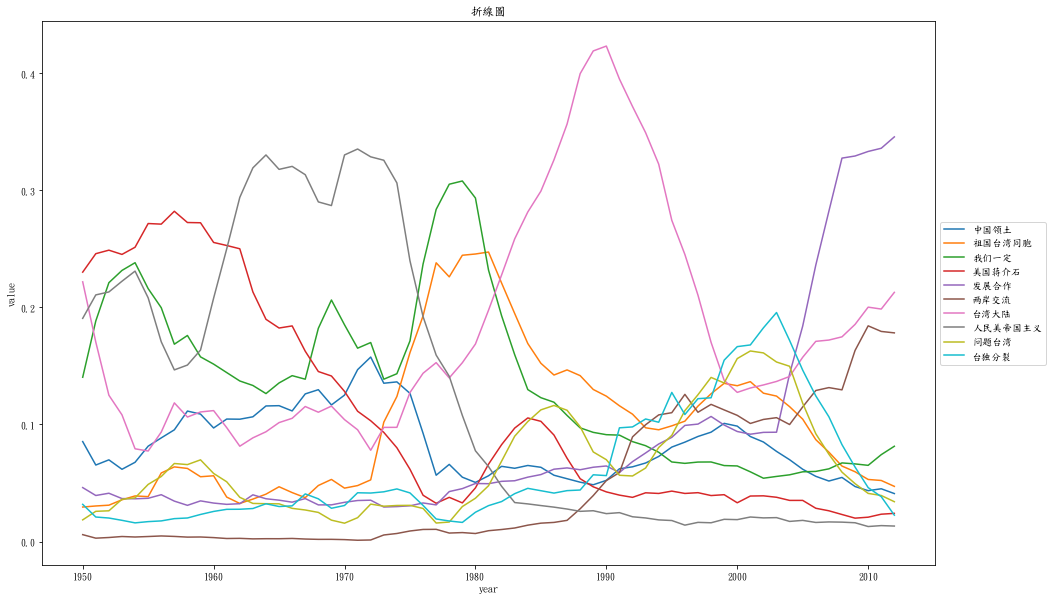

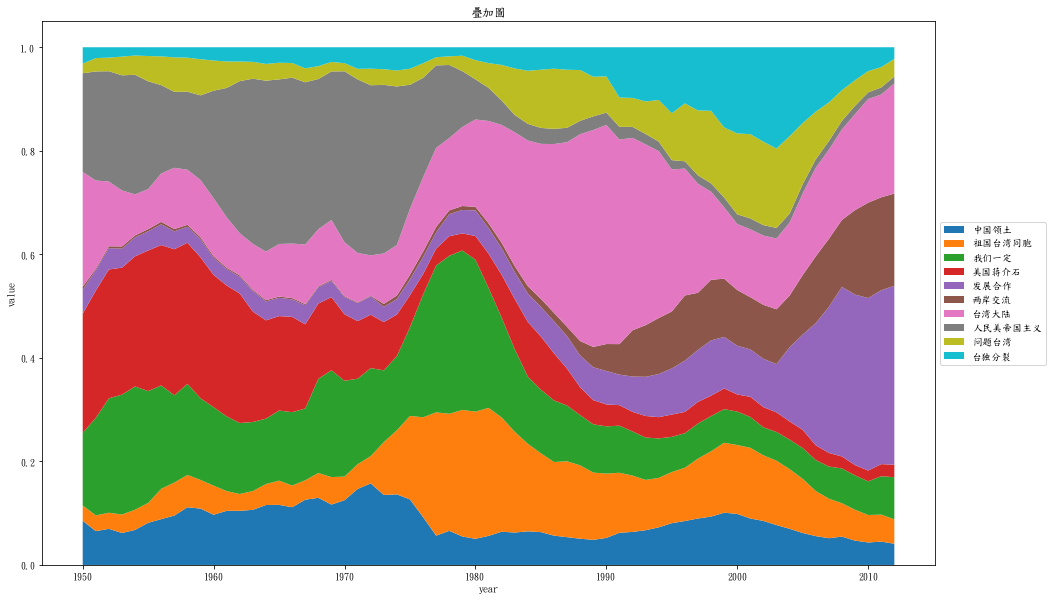

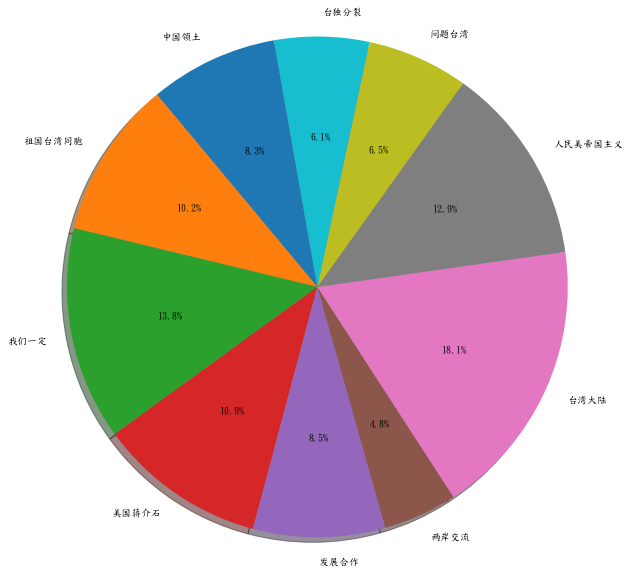

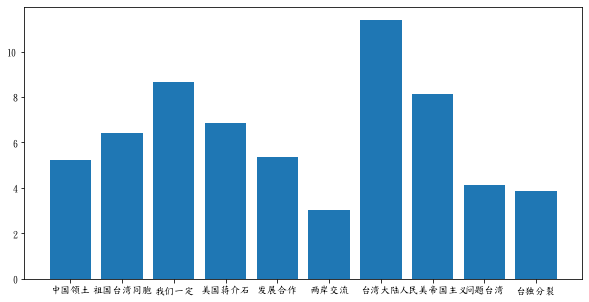

In [ ]:
rolling=5
ts= plot_topic_model(df_lsa,labels,rolling=5)

# @ 文章分群

In [ ]:
def cluster_analysis(df, field,pth,title, method='svd',num_i=100, n_clus=10):
    if field not in ['textrank','tfidf','token']:
        print ('field 必是須 textrank,tfidf,token 三者之一')
        return
    # 文章字詞矩陣
    print ('tfidf......')
    # list of 空白隔開之 string
    if field in ['textrank','tfidf']:
        df[field]=df[field].str.replace(',',' ')   
    doc_list=df[field]
    
    ngram=(1,1)
    vectorizer = TfidfVectorizer(min_df = 1,ngram_range= ngram)
    dtm_tfidf = vectorizer.fit_transform(doc_list) # sparse matrix
    # 字詞的編號
    terms=vectorizer.vocabulary_
    # 字詞的 list
    term_list=vectorizer.get_feature_names_out()
    
    print ('降維 ......')
    if method=="svd":
        lsa = TruncatedSVD(num_i, algorithm = 'arpack')   # object
    elif method=="lda":
        lsa=LatentDirichletAllocation(num_i)
    elif method=="nmf":    
        lsa= NMF(num_i)   # 各投影值只有正值，沒有負值    

    dtm_lsa = lsa.fit_transform(dtm_tfidf)  # 加權
    dtm_com = lsa.fit(dtm_tfidf)  # object, not numpy array     

    # 標準化 dtm_lsa_n, 
    dtm_lsa_n = Normalizer(copy=False).fit_transform(dtm_lsa)

    # explained_variance_ratio
    ratio=lsa.explained_variance_ratio_    
    print ("total explained ratio ",sum(ratio))

    # 字詞的編號
    terms=vectorizer.vocabulary_

    # 字詞的 list
    term_list=vectorizer.get_feature_names_out() 

    # 指定要分的群組數目--------------------------------     
    print ('kmeans 分群......')
    n_clus=10
    # dtm_lsa 作為分群的依據，呼叫 KMeans 函數
    kmeans = KMeans(n_clusters=n_clus, random_state=0).fit(dtm_lsa_n)

    # 算出各群中心點座標
    cen=kmeans.cluster_centers_

    # cluster 的類別
    cluster=list(kmeans.labels_)

    ## 分群結果增加新欄位 ---------------------------------------
    df['cluster']=cluster  

    # 各群組內的文章 token 合併成 string
    clus_token=[]
    for n in range(n_clus):
        string=''
        df_sel=df[df.cluster==n]
        for n in range(len(df_sel)):
            string=string + ' ' +df_sel[field].iloc[n]
        clus_token.append(string)   

    ## 計算各類文章的比例----------------------------------------
    print ('計算各類文章的總數與比例......')
    count=[]
    year=sorted(list(df.year.unique()))
    for y in year:
        df_year=df[df.year==y]
        a=df_year['cluster'].value_counts() 
        df_cluster = pd.DataFrame(a).sort_index(ascending=True)
        # 如果某個年度，某個群數為0
        if len(year)>len(df_cluster):
            count_y=[]
            for n in range(max(cluster)+1):
                try:           
                    count_y.append(int(df_cluster.loc[n]))   
                except:
                    count_y.append(0)       
        else:                   
            count_y=list(df_cluster.cluster)

        rate_y=[]
        for c in count_y:    
            if sum(count_y)>0:
                rate=c/sum(count_y)                    
            else:
                rate=0
            rate_y.append(rate)    
        count.append(rate_y)
    df_rate=pd.DataFrame(count, index=year,columns=range(max(cluster)+1))

    ## 加總各類文章篇數 -------------------------------------------
    count=[]
    for y in year:
        df_year=df[df.year==y]
        a=df_year['cluster'].value_counts() 
        df_cluster = pd.DataFrame(a).sort_index(ascending=True)
        # 如果某個年度，群數不全，某個群數為 0
        if len(year)>len(df_cluster):
            count_y=[]
            for n in range(max(cluster)+1):
                try:           
                    count_y.append(int(df_cluster.loc[n]))   
                except:
                    count_y.append(0)       
        else:                   
            count_y=list(df_cluster.cluster)   
        count.append(count_y)
    df_count=pd.DataFrame(count, index=year,columns=range(max(cluster)+1))
    
    print ('各群最常出現的 30 關鍵字詞......')
    # 各群最常出現的 30 關鍵字詞
    import collections
    clus_most=[]
    for c in range(len(clus_token)):
        word_list=clus_token[c].split()
        counter=collections.Counter(word_list)
        most_term=counter.most_common(30)
        wrd_dict=dict(most_term) 
        clus_most.append(wrd_dict.keys())
    df_clus_most=pd.DataFrame(clus_most).T
    
    # save，必須要有 data 次目錄  -------------------------------   
    print('save.....')
    try:
        fname=pth+"data/"+title+"_"+"df"+".xlsx"
        writer = pd.ExcelWriter(fname)
        df.to_excel(writer,'Sheet1',encoding='utf-8')
        writer.save() 
        print ('save', fname)
    except:  # 如果檔案太大則存 pkl 檔
        fname=pth+"data/"+title+"_"+"df"+".pkl"
        with open(fname, "wb") as fp:   #Pickling
            pickle.dump(clus_token, fp) 
        print ('save', fname)    
        
    fname=pth+"data/"+title+"_"+"clus_token"+".pkl"
    with open(fname, "wb") as fp:   #Pickling
        pickle.dump(clus_token, fp)  
        print ('save', fname)

    fname=pth+"data/"+title+"_"+"df_rate"+".xlsx"
    writer = pd.ExcelWriter(fname)
    df_rate.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save()        
    print ('save', fname)
    
    fname=pth+"data/"+title+"_"+"df_count"+".xlsx"
    writer = pd.ExcelWriter(fname)
    df_count.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save()    
    print ('save', fname)
    
    fname=pth+"data/"+title+"_"+"df_clus_most"+".xlsx"
    writer = pd.ExcelWriter(fname)
    df_clus_most.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save()    
    print ('save', fname)    
    return df, clus_token, df_rate, df_count, df_clus_most

In [ ]:
# 文本分群 要花時間
field='token'
num_i=100
n_clus=10
(df_cl, clus_token, df_rate, df_count, df_clus_most)= cluster_analysis(df, field,pth,title, method='svd', num_i=100, n_clus=10)

In [ ]:
df_clus_most

,0,1,2,3,4,5,6,7,8,9
0,，,，,，,，,，,的,的,，,，,，
1,的,的,的,的,的,，,，,的,的,的
2,。,。,。,。,。,。,。,。,。,。
3,和,大陆,在,台湾,和,美国,人民,和,两岸,“
4,在,台湾,和,“,我们,“,和,在,“,”
5,发展,“,“,”,在,”,中国,“,”,中国
6,合作,”,”,在,了,在,在,”,和,是
7,中国,在,了,了,是,和,了,了,在,台湾
8,了,和,台湾,是,”,台湾,是,是,台湾,在
9,与,了,是,和,“,是,“,发展,了,和


## 定義 labels

In [ ]:
# 定義 labels 取前兩個詞
n_clus=10
a=list(df_clus_most.iloc[0])[len(df_clus_most.columns)-n_clus:]
b=list(df_clus_most.iloc[1])[len(df_clus_most.columns)-n_clus:]
labels=[]
for n in range(len(a)):
    labels.append(a[n]+b[n])
labels

['，的', '，的', '，的', '，的', '，的', '的，', '的，', '，的', '，的', '，的']

## 繪圖

In [ ]:
def plot_cluster_analysis(df, labels ,pth="/content/drive/MyDrive/my python/people/",rolling=1):
    # df 以文本為單位，必須有 year, cluster 欄位，自動計算 rate, count by year
    # cluster 為類別，從0 起算之數字序號
    # line, bar, pie, agrigate 全部都會畫
    import matplotlib.pyplot as plt 
    # 中文設定
    from matplotlib import rcParams
    rcParams["font.sans-serif"] = ["kaiu"] 
    rcParams["font.family"] ="DFKai-sb"
    
    ## 計算各類文章的比例
    print ("calculate rate......")
    count=[]
    year=sorted(list(df.year.unique()))
    n_clus=len(df.cluster.unique()) 
    if labels==[]:
        labels=list(range(n_clus))
    
    for y in year:
        df_year=df[df.year==y]
        a=df_year['cluster'].value_counts() 
        df_cluster = pd.DataFrame(a).sort_index(ascending=True)
        # 如果某個年度， 群組數目有缺
        if n_clus>len(df_cluster):
            count_y=[]
            for n in range(n_clus):
                try:           
                    count_y.append(int(df_cluster.loc[n]))   
                except:
                    count_y.append(0)       
        else:                   
            count_y=list(df_cluster.cluster)

        rate_y=[]
        for c in count_y:    
            if sum(count_y)>0:
                # 百分比
                rate=c/sum(count_y)                    
            else:
                rate=0
            rate_y.append(rate)    
        count.append(rate_y)
        print (y,end=" ")
    df_rate=pd.DataFrame(count, index=year,columns=range(n_clus))

    ## 加總各類文章篇數
    print ("count ......")
    count=[]
    for y in year:
        df_year=df[df.year==y]
        a=df_year['cluster'].value_counts() 
        df_cluster = pd.DataFrame(a).sort_index(ascending=True)
        # 如果某個年度，某個群數為0
        if len(year)>len(df_cluster):
            count_y=[]
            for n in range(n_clus):
                try:           
                    count_y.append(int(df_cluster.loc[n]))   
                except:
                    count_y.append(0)       
        else:                   
            count_y=list(df_cluster.cluster)   
        count.append(count_y)
        print (y,end=" ")
    df_count=pd.DataFrame(count, index=year,columns=range(n_clus))
    
    # 如果有 labels, cluster 替代為 labels
    if len(labels)!=n_clus:
         labels=list(range(n_clus)) 

    ## 分群數量，時間趨勢圖 ----------------------------------------------------
    fig, ax = plt.subplots(figsize=(16,10))
    year=sorted(set(df.year.unique()))
    for c in range(n_clus): 
        ax.plot(year, df_count[c].rolling(rolling).mean(), label=labels[c])      
    ax.set_xticks([1950,1960,1970,1980,1990,2000,2010])

    # 圖例位置由程式自己決定
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    ax.set_xlabel('year')     # X label
    ax.set_ylabel('freq.')    # y lobel
    ax.set_title('數量 by year and cluster');   # title
    plt.show()

    ## 分群比例，時間趨勢圖 -----------------------------------------------------
    fig, ax = plt.subplots(figsize=(16,10))
    year=sorted(set(df.year.unique()))
    for c in range(n_clus): 
         ax.plot(year, df_rate[c].rolling(rolling).mean(), label=labels[c])      
    ax.set_xticks([1950,1960,1970,1980,1990,2000,2010])

    ax.legend(loc=1);  
    ax.set_xlabel('year')     # X label
    ax.set_ylabel('freq.')    # y lobel
    ax.set_title('比例 by year and cluster');   # title
    plt.show()

    ## 各群文章 count 時間疊加圖 -------------------------------------------------------
    fig, ax = plt.subplots(figsize=(16,10))
    ax.set_xticks([1950,1960,1970,1980,1990,2000,2010])
    for n in range(len(labels)):
        df_count[n]=df_count[n].rolling(rolling).mean()
    if n_clus==2:
        plt.stackplot(year, df_count[0],df_count[1], labels=labels)
    elif n_clus==3:
        plt.stackplot(year, df_count[0],df_count[1],df_count[2], labels=labels)
    elif n_clus==4:
        plt.stackplot(year, df_count[0],df_count[1],df_count[2],df_count[3], labels=labels)        
    elif n_clus==5:
        plt.stackplot(year, df_count[0],df_count[1],df_count[2],df_count[3],df_count[4], labels=labels)         
    elif n_clus==6:
        plt.stackplot(year, df_count[0],df_count[1],df_count[2],df_count[3],df_count[4],df_count[5], labels=labels)           
    elif n_clus==7:
        plt.stackplot(year, df_count[0],df_count[1],df_count[2],df_count[3],df_count[4],df_count[5],df_count[6], labels=labels)         
    elif n_clus==8:
        plt.stackplot(year, df_count[0],df_count[1],df_count[2],df_count[3],df_count[4],df_count[5],df_count[6],df_count[7],labels=labels)          
    elif n_clus==9:
        plt.stackplot(year, df_count[0],df_count[1],df_count[2],df_count[3],df_count[4],df_count[5],df_count[6],df_count[7],df_count[8],labels=labels)  
    elif n_clus==10:
        plt.stackplot(year, df_count[0],df_count[1],df_count[2],df_count[3],df_count[4],df_count[5],df_count[6],df_count[7],df_count[8],df_count[9],labels=labels)     

    # 圖例位置由程式自己決定
    ax.legend(loc=0);  
    ax.set_xlabel('year')     # X label
    ax.set_ylabel('number')    # y lobel
    ax.set_title('數量 by year and cluster');   # title
    plt.show()
    fig, ax = plt.subplots(figsize=(16,10))
    ax.set_xticks([1950,1960,1970,1980,2000,2010])

    # rate繪疊加圖 
    for n in range(len(labels)):
        df_rate[n]=df_rate[n].rolling(rolling).mean()
                
    if n_clus==2:
        plt.stackplot(year, df_rate[0],df_rate[1], labels=labels)
    elif n_clus==3:
        plt.stackplot(year, df_rate[0],df_rate[1],df_rate[2], labels=labels)
    elif n_clus==4:
        plt.stackplot(year, df_rate[0],df_rate[1],df_rate[2],df_rate[3], labels=labels)        
    elif n_clus==5:
        plt.stackplot(year, df_rate[0],df_rate[1],df_rate[2],df_rate[3],df_rate[4], labels=labels)         
    elif n_clus==6:
        plt.stackplot(year, df_rate[0],df_rate[1],df_rate[2],df_rate[3],df_rate[4],df_rate[5], labels=labels)           
    elif n_clus==7:
        plt.stackplot(year, df_rate[0],df_rate[1],df_rate[2],df_rate[3],df_rate[4],df_rate[5],df_rate[6], labels=labels)         
    elif n_clus==8:
        plt.stackplot(year, df_rate[0],df_rate[1],df_rate[2],df_rate[3],df_rate[4],df_rate[5],df_rate[6],df_rate[7],labels=labels)          
    elif n_clus==9:
        plt.stackplot(year, df_rate[0],df_rate[1],df_rate[2],df_rate[3],df_rate[4],df_rate[5],df_rate[6],df_rate[7],df_rate[8],labels=labels)  
    elif n_clus==10:
        plt.stackplot(year, df_rate[0],df_rate[1],df_rate[2],df_rate[3],df_rate[4],df_rate[5],df_rate[6],df_rate[7],df_rate[8],df_rate[9],labels=labels)      

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    ax.set_xlabel('year')     # X label
    ax.set_ylabel('number')    # y lobel
    ax.set_title('比例 by year and cluster');   # title
    plt.show()

    # 圓餅圖 --------------------------------------------
    # percent of each cluster
    cluster=list(df.cluster)
    percent=[]
    for c in range(n_clus): 
        percent.append(cluster.count(c)/len(cluster))

    patches, texts = plt.pie(percent,labels=labels,shadow=False, startangle=90)
    #patches, texts = plt.pie(percent,labels=labels,autopct='%1.1f%%',shadow=False, startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # 長條圖 --------------------------------------------
    # percent of each cluster
    total=[]
    for c in range(n_clus): 
        total.append(cluster.count(c))
    plt.bar(labels,total)
    plt.show()
    return df_count, df_year

## show

calculate rate......
1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 count ......
1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 

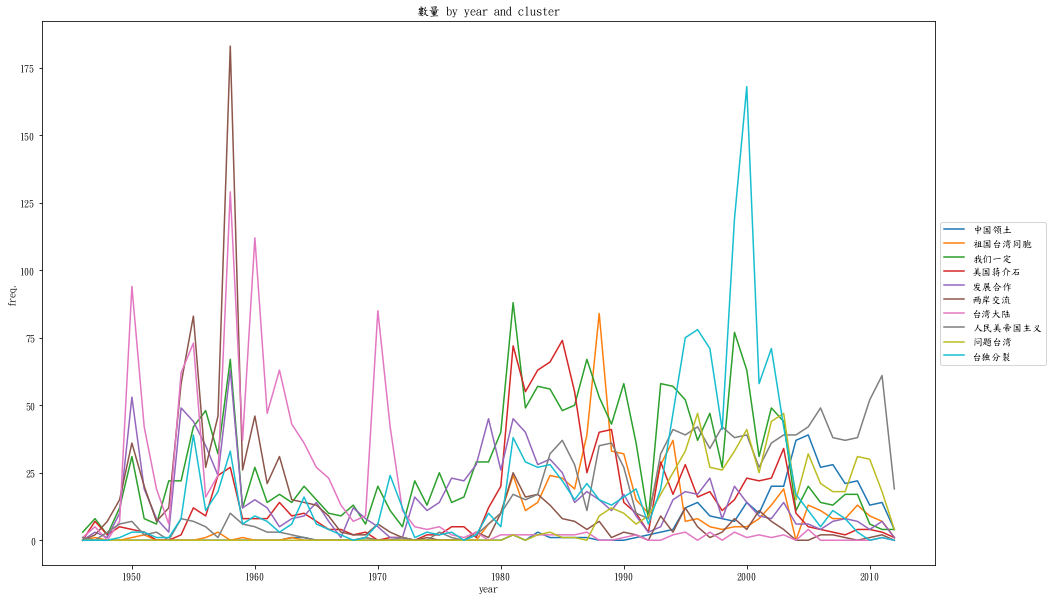

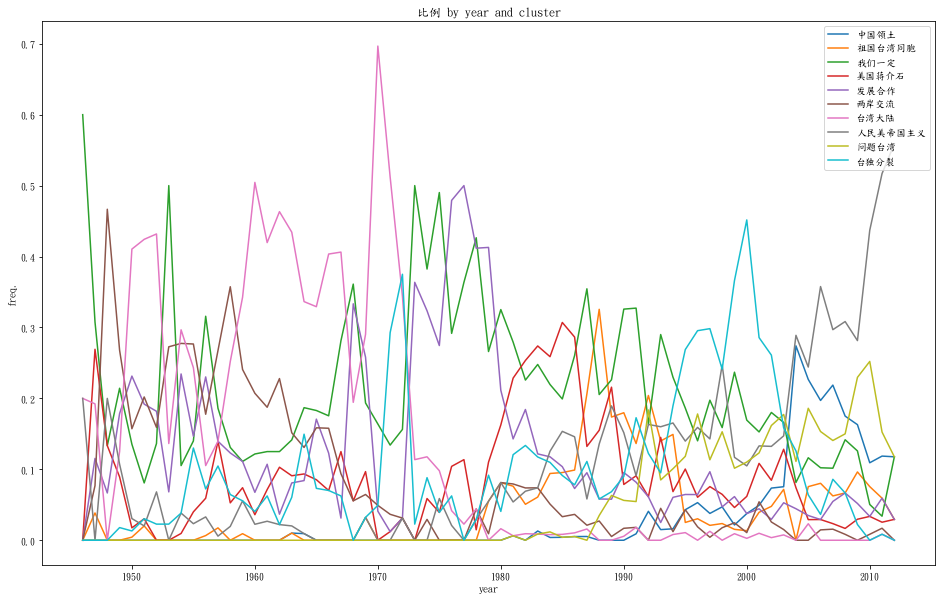

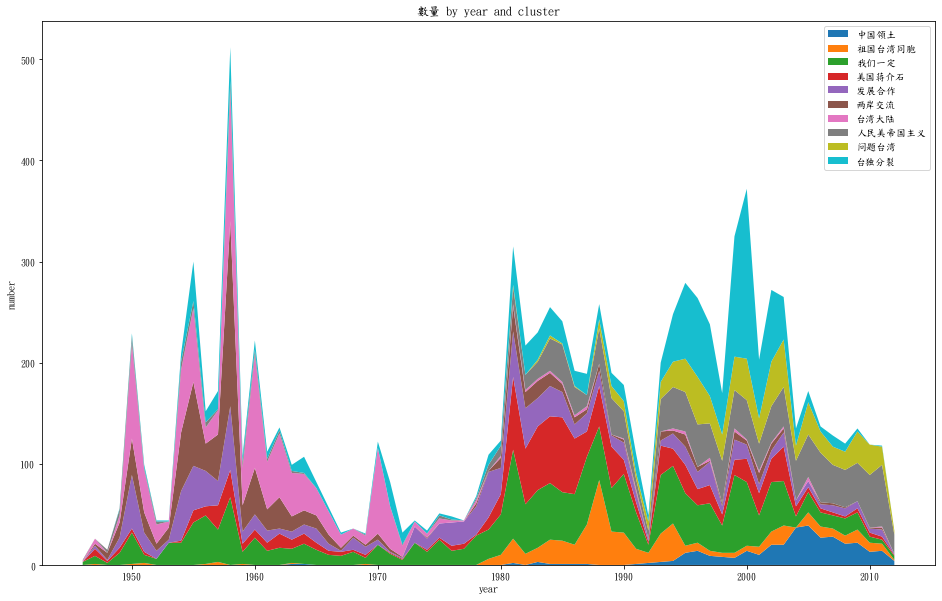

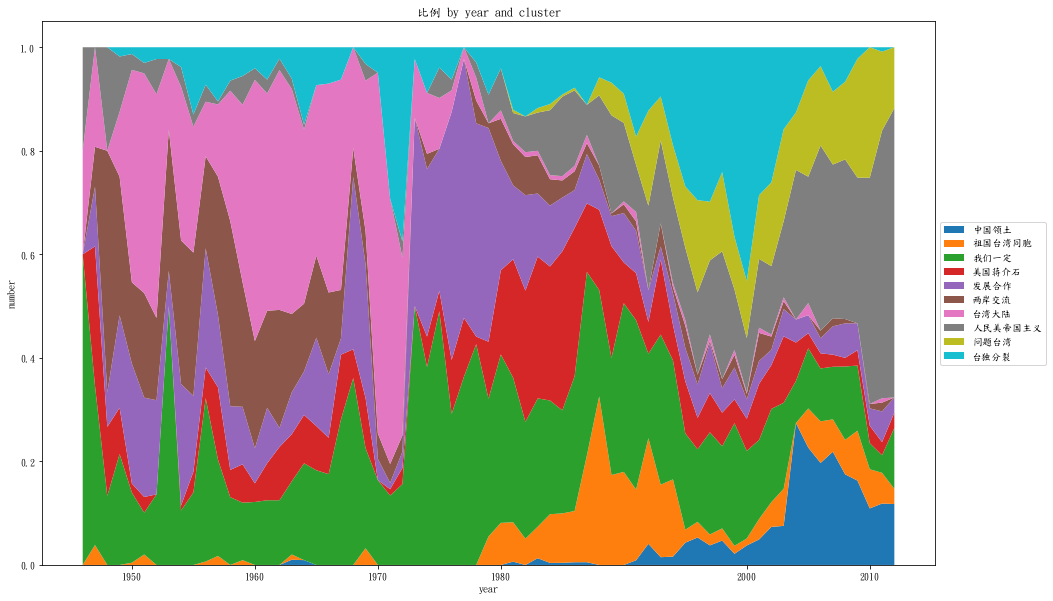

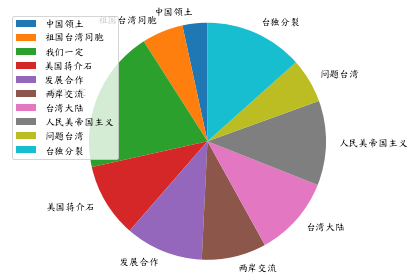

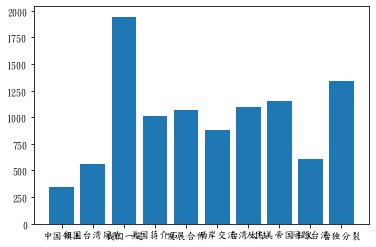

In [ ]:
(df_count, df_year)= plot_cluster_analysis(df, labels,pth, rolling=1)

# @ 潛在語意分析

In [ ]:
def lsa_concept( df, field='textrank', num_i=100,  pth="/content/drive/MyDrive/my python/people/",title='concept'):
    if field not in ['textrank','tfidf','token']:
        print ('field 必是須 textrank,tfidf,token 三者之一')
        return
    # tfidf 加權
    # list of 空白隔開之 string
    if field in ['textrank','tfidf']:
        df[field]=df[field].str.replace(',',' ')      
    
    doc_list=df[field].str.replace(","," ")

    # Term document frequency 轉換，成為 matrix ,
    transformer = TfidfVectorizer()
    tfidf = transformer.fit_transform(doc_list)     # sparse matrix
    # 字詞的編號
    terms=transformer.vocabulary_
    # 字詞的 list
    term_list=transformer.get_feature_names_out()
    
    # latent semantic analysis, 變數縮減
    svd = TruncatedSVD(num_i, algorithm = 'arpack')   # object
    lsa = svd.fit_transform(tfidf.T)  # numpy array, (number of terms * num_i)     

    dtm_lsa = svd.fit_transform(tfidf)  
    dtm_com = svd.fit(tfidf)  # object, not numpy array
    # components
    comp=dtm_com.components_
    print("維度數",len(comp))
    print("字詞數",len(comp[0]))
    
    # 每個維度軸都是各字詞的線性組合，每個維度的構成
    df_concept=pd.DataFrame(comp,columns= term_list)
    df_concept=df_concept.transpose()
    # 各維度字詞，依重要性大小排序
    con=[]
    sig=[]
    for n in range(len(df_concept.columns)):
        # 由大至小排序
        df_order= df_concept.sort_values(by=n, ascending=False)
        con.append(list(df_order.index)[0:500])
        sig.append(list(df_order[n])[0:500])
    # 印出各軸的重要字詞
    for n in range(len(con)):
        print (n,con[n][:30])    
        
    # 轉成 dataframe 格式
    df_concept=pd.DataFrame(con).T
    
    # save，必須要有 data 次目錄     
    fname=pth+"data/"+title+"_df_concept.xlsx"
    np.save(fname, lsa)

    fname=pth+"data/"+title+"_lsa.xlsx"
    writer = pd.ExcelWriter(fname)
    df_concept.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save()      
    
    return df_concept, transformer, lsa, term_list

In [ ]:
# 降維 要花時間
title='lsa'
field='token'
num_i=10
(df_concept, transformer, lsa, term_list)= lsa_concept(df, field, num_i, pth,title)

維度數 10
字詞數 77637
0 ['中国', '人民', '台湾', '我们', '美国', '问题', '发展', '两岸', '美帝国主义', '领土', '祖国', '我国', '侵略', '日本', '反对', '和平', '国家', '进行', '支持', '他们', '表示', '实现', '合作', '解放台湾', '斗争', '大陆', '关系', '台湾同胞', '一个', '和平统一']
1 ['两岸', '发展', '两岸关系', '合作', '问题', '交流', '大陆', '经济', '和平统一', '推动', '促进', '台湾同胞', '双方', '实现', '同胞', '台独', '台湾当局', '关系', '台湾', '希望', '记者', '共同', '投资', '海峡两岸', '一个中国', '稳定', '一国两制', '分裂', '祖国', '坚持']
2 ['我们', '人民', '祖国', '解放台湾', '社会主义', '美帝国主义', '斗争', '一定', '台湾同胞', '建设', '我国', '全国', '两岸', '毛主席', '实现', '工作', '同胞', '胜利', '坚决', '团结', '伟大', '同志', '革命', '解放', '和平统一', '中国共产党', '完成', '事业', '两岸关系', '领导']
3 ['美国', '大陆', '两岸', '台湾', '日本', '侵略', '集团', '蒋介石', '他们', '投资', '进行', '经济', '交流', '台北', '军事', '战争', '国民党', '亚洲', '台商', '活动', '消息', '报纸', '报道', '企业', '南朝鲜', '工作', '台湾海峡', '参加', '我国', '台胞']
4 ['合作', '发展', '双方', '关系', '加强', '人民', '领域', '日本', '中方', '交流', '经济', '美帝国主义', '两国', '侵略', '支持', '胡锦涛', '亚洲', '建设', '两国关系', '推动', '地区', '两岸', '朝鲜', '进一步', '重要', '两国人民', '共同', '友好合作', '不断', '扩大']
5 ['两岸', '两岸

## show

In [ ]:
k=30
term='台湾'
closest= people.kClosestTerms(k,term,transformer,lsa,term_list)
closest

----------------

['台湾',
 '允许',
 '今日',
 '必要措施',
 '私下',
 '看一看',
 '最初',
 '两种',
 '一千五百万',
 '明说',
 '深表遗憾',
 '五十个',
 '调子',
 '含有',
 '票数',
 '刊登',
 '政界人士',
 '吏治',
 '废弛',
 '奢靡',
 '前不久',
 '从中',
 '答复',
 '仔细',
 '时报',
 '昨天',
 '要员',
 '心知肚明',
 '广为人知',
 '吹牛']

# @ 詞對分析
* 詞對分析由於需要字詞的排列順序，無法用 textrank，因此用 token 欄位替代。
* 先篩選所有有關台灣的句子。

In [ ]:
# 計算卡方值
def chisquare(o11, o12, o21, o22):
    n = o11 + o12 + o21 + o22
    x_2 = (n * ((o11 * o22 - o12 * o21)**2)) / ((o11 + o12) * (o11 + o21) * (o12 + o22) * (o21 + o22)) 
    return x_2

def corpus_map_year(df,kw, corpus,window, path,title='corpus'):

    if 'token' not in list(df.columns):
        print ('df 必須要有 token 欄位')
        return
 
    # 讀取語料庫, list
    corpus_list=corpus.copy()
    corpus=[]
    for c in corpus_list:
        string="open(path" +"+"+ "'corpus/"+c+".txt'"+",'r',encoding='utf-8').read().split()"
        corpus.append(eval(string))

    ## 一年合併成一個文字檔，以年作為分析單位
    import re
    tokens=[]
    years=[]
    target=[]
    year=sorted(list(df.year.unique()))
    for n in range(len(year)):
        str_year=''
        i=0
        df1=df[(df.year==year[n])]     
        # 文章 list
        token=list(df1.token)  
        for t in range(len(token)):
            if type(token[t])== str:   
                str_year+="。"+token[t]                                                                             
                i+=1                             
        tokens.append(str_year)      
        years.append(year[n])
        target.append(i)
        print (years[n],"done",i,"found", end=" ")    

    data=list(zip(years, target,tokens))
    df_year=pd.DataFrame(data, columns=["year","target","tokens"])          

    ## 詞頻計算，分年度計算
    word_count_years=[]
    for n in range(len(year)):
        # 轉為 list
        if pd.isna(tokens[n])==False:
            tok=re.split(r'[。 ]',tokens[n])
            word_counts = Counter(tok)
            word_count_years.append(dict(word_counts.most_common()))    
        else:
            word_count_years.append(dict())

    ## 詞對計算，分年度計算
    # 累計配對的次數
    pair_count_years=[]
    bigrams_years=[]
    for n in range(len(year)):    
        word_pair_count=Counter()
        word1=[]
        word2=[]
        num_bigrams=0
        if pd.isna(tokens[n])==False:
            tok=re.split(r'[。 ]',tokens[n])
            # i 是啟始位置
            for i in range(len(tok)-1):
                # j 是間隔 1 表下一個
                for j in range(1,window+1):  
                    # 啟始加間隔，總共要小於總長度，因為從0起算
                    if i+j < len(tok):  
                        # 詞對
                        (w1,w2)=tok[i],tok[i+j]
                        # 大於一個字方納入
                        if len(w1)>1 and len(w2)>1:
                            word_pair_count[(w1,w2)]+=1                  
                            num_bigrams += 1          
        bigrams_years.append(num_bigrams)                    
        pair_count_years.append(word_pair_count.most_common())   

    # 計算卡方值
    pair_chi_squares_year=[]
    for n in range(len(year)):
        pair_chi_squares = Counter()
        # 從詞對計算卡方值
        for (w1, w2), w1_w2_count in pair_count_years[n]:
            if w1 in kw or w2 in kw:
                # O12
                w1_only_count = word_count_years[n][w1] - w1_w2_count
                # O21
                w2_only_count = word_count_years[n][w2] - w1_w2_count
                # O22
                rest_count = bigrams_years[n] - w1_only_count - w2_only_count - w1_w2_count
                # O11= w1_w2_count
                pair_chi_squares[(w1, w2)] = chisquare(w1_w2_count, w1_only_count, w2_only_count, rest_count)
                pair_chi_squares[(w1, w2)] =pair_chi_squares[(w1, w2)]
        pair_chi_squares_year.append(pair_chi_squares.most_common())        

    # 語料庫圖譜
    target=df_year.target
    count_total_year=[]
    for n in range(len(year)):  
        count_total=[]
        if target[n]>0:        
            # target 是前面已計算的標的詞數目
            count_total.append(target[n])
            # 卡方值最高的 200個詞對 #######   
            temp=pair_chi_squares_year[n]
            if len(temp)>=200:
                k=100
            else:
                k=len(temp)
            word=[]        
            for m in range(k):
                if temp[m][0][0] in kw:
                    word.append((temp[m][0][1],round(temp[m][1],0)))
                else:
                    word.append((temp[m][0][0],round(temp[m][1],0)))                                       
            count_total.append(word)
            # 各年度 pair_count_years 轉為 dictionary
            dic=dict(pair_count_years[n])  
            # 每個 corpus 依序計算  
            for c in range(len(corpus)):     
                # w1 w2 其一為標的字詞
                for k in kw:
                    word1=[]
                    word2=[]
                    num=[]
                    for (w1, w2) in dic:
                        # 合於 corpus 條件者選取
                        if (w1 == k and w1!=w2 and w2 in corpus[c]) or (w2 == kw and w1!=w2 and w1 in corpus[c]):     
                            word1.append(w1)
                            word2.append(w2)
                            num.append(dic[(w1, w2)])        
                    edges=list(zip(word1, word2, num))
                    # dataframe
                    dfs=pd.DataFrame(edges,columns=["word1","word2","num"])
                    # 排序
                    dfs=dfs.sort_values(by=['num'],ascending=False)
                    # 取前 200 個 #######################
                    dfs=dfs.iloc[:200]   
                # 詞對數目加入 corpus_count    
                temp=dfs.values.tolist()
                word=[]
                # 只顯示共現詞
                for m in range(len(temp)):
                    if temp[m][0] in kw:
                        word.append((temp[m][1],temp[m][2]))
                    else:
                        word.append((temp[m][0],temp[m][2]))                                       
                count_total.append(word)
        else:
            count_total.append(target[n])
            for k in range(len(corpus)):
                count_total.append(np.nan)

        # 各個年度計算   
        count_total_year.append(count_total)
    df_corpus=pd.DataFrame(count_total_year,columns=[title,"詞對"]+corpus_list,index=year)
    # save excel files
    fname=pth+"data/"+title+"_corpus_map_year.xlsx"
    writer = pd.ExcelWriter(fname)
    df_corpus.to_excel(writer,'Sheet1',encoding='utf-8')
    writer.save()
    return df_corpus

In [ ]:
corpus=["革命楷模","歷史人物","黨國幹部","文藝學者","官職","會議","政策目標","政策作為","政策議題","貶抑詞","反革命","鬥爭","歌功頌德","效忠黨國",
        "褒獎詞"]
window=3
title='台湾'
kw=['台湾']
path="d:/my python/people/"
df_corpus= people.corpus_map_year(df,kw, corpus,window, path,title)

NameError: name 'path' is not defined

## show

In [ ]:
df_corpus

,台湾,詞對,革命楷模,歷史人物,黨國幹部,文藝學者,官職,會議,政策目標,政策作為,政策議題,貶抑詞,反革命,鬥爭,歌功頌德,效忠黨國,褒獎詞
1946,5,"[(人民, 123.0), (已有, 93.0), (数百个, 93.0), (军官, 93...",[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1947,26,"[(人民, 118.0), (生俘, 105.0), (大刚, 105.0), (通讯, 1...",[],[],"[(熊式辉, 1)]",[],"[(战士, 1)]",[],[],[],"[(部队, 1), (工商业, 1)]","[(反抗, 1), (欺骗, 1)]","[(暴动, 1)]",[],[],[],[]
1948,15,"[(工农, 365.0), (捕鱼, 238.0), (中心, 180.0), (渔业, 1...",[],[],[],[],[],[],"[(独立, 2), (解放, 1)]",[],[],"[(侵略, 2)]","[(美帝, 1), (蒋匪, 1)]",[],[],[],[]
1949,56,"[(海南岛, 530.0), (飞抵, 372.0), (东南, 332.0), (要求, ...",[],[],"[(高山族, 1)]","[(谢雪红, 1)]","[(代表, 1)]",[],"[(解放, 3), (独立, 1)]",[],"[(经济, 3), (学生, 1), (土地, 1), (农村, 1), (生活, 1), ...","[(阴谋, 4), (掠夺, 1), (匪军, 1)]","[(国民党, 3), (反动派, 2), (反共, 1), (反动, 1), (国民党军, 1)]","[(阴谋, 4)]",[],[],[]
1950,229,"[(侵略, 2658.0), (侵占, 1706.0), (朝鲜, 1303.0), (武装...",[],"[(蒋介石, 3)]","[(以后, 1)]","[(谢雪红, 1)]",[],"[(大会, 5), (动员大会, 1)]","[(解放, 16)]",[],"[(军事, 3), (经济, 2), (农产, 1), (土地, 1), (学生, 1), ...","[(侵略, 12), (罪行, 3), (匪帮, 3), (阴谋, 1), (屠杀, 1),...","[(国民党, 9), (残匪, 3), (美帝国主义, 2), (反动派, 1), (反动势...","[(阴谋, 1), (肃清, 1), (攻击, 1), (动员大会, 1), (粉碎, 1)]",[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,120,"[(渔船, 2413.0), (涉藏, 1955.0), (合法政府, 1409.0), (...",[],"[(张学良, 1)]",[],[],"[(主任, 2), (体委, 1)]",[],"[(现代化, 1)]",[],"[(经济, 12), (青年, 2), (生产, 1), (劳动, 1), (工业, 1),...",[],"[(国民党, 1)]",[],[],"[(团结, 1)]",[]
2009,135,"[(涉藏, 3266.0), (同学, 2189.0), (关系法, 1976.0), (寄...",[],[],"[(刘谦, 1), (张克辉, 1), (温家宝, 1)]","[(张克辉, 1), (林盛中, 1)]","[(代表, 7), (理事长, 2), (主任, 2), (上将, 1), (校长, 1),...",[],"[(开放, 3), (独立, 2), (统一, 1)]",[],"[(学生, 6), (经济, 5), (文化, 3), (工业, 3), (市场, 2), ...","[(犯罪, 4), (诈骗, 2), (分化, 1)]","[(特务, 1), (里应外合, 1)]","[(打击, 1)]",[],[],"[(丰富, 1)]"
2010,119,"[(涉藏, 1274.0), (涉疆, 918.0), (童谣, 918.0), (爱盲, ...",[],[],"[(刘昌, 1)]",[],"[(代表, 6), (主席, 3), (总理, 1)]",[],"[(统一, 2)]",[],"[(文化, 6), (经济, 5), (学生, 3), (电子, 2), (工业, 2), ...","[(落后, 2)]",[],[],[],[],[]
2011,118,"[(涉藏, 3963.0), (关系法, 3963.0), (涉疆, 2910.0), (出...",[],[],"[(邵琪伟, 1)]",[],"[(首席代表, 1), (主席, 1)]",[],[],[],"[(武器, 9), (经济, 3), (农业, 2), (技术, 2), (生活, 2), ...","[(犯罪, 2), (诈骗, 1), (反抗, 1)]","[(国民党, 1)]","[(打击, 1)]",[],[],[]


# word2vec詞向量

In [ ]:
import gensim
fname="D:/my python/people/working/w2v_model.txt" 
model = gensim.models.Word2Vec.load(fname)  # you can continue training with the loaded model!

In [ ]:
# 字詞的向量
a=model.wv['台湾']  # numpy vector of a word
a

array([ 4.1991358e+00, -3.0105925e+00, -2.7386882e+00, -4.6797600e+00,
        1.8866299e+00,  5.8215437e+00,  9.3276519e-01,  5.2931738e+00,
       -2.7273712e+00,  7.4080019e+00, -6.6017640e-01,  3.4043744e+00,
       -4.3418946e+00, -5.2027826e+00, -9.6073132e-03,  6.5433922e+00,
        7.8459172e+00, -7.5976400e+00, -1.8406432e+00, -4.3923807e+00,
       -1.4355534e+00, -1.1301353e+00,  7.0246011e-01, -8.4825010e+00,
        2.8957123e-02,  3.1704404e+00, -5.1508293e+00,  1.2540920e+00,
       -2.1897664e+00,  2.1613033e+00, -1.6990650e+00, -3.3962457e+00,
       -5.8181381e+00,  8.0681801e+00, -6.8842521e+00, -7.9908860e-01,
       -5.8981407e-01,  2.8358645e+00, -5.7380786e+00, -4.7636218e+00,
        3.4119043e+00,  6.2334733e-03,  3.4191060e+00, -7.5716197e-02,
        1.7337295e+00, -7.4638276e+00, -1.5402659e+00, -2.4548755e+00,
       -5.1143436e+00,  3.2492027e+00, -1.8065994e+00,  1.6939554e+00,
       -7.1433711e-01, -5.6886810e-01,  1.9525521e+00,  1.1175520e+00,
      

## 字詞的相似性

In [ ]:
model.wv.similarity('台湾','大陆')

0.7994515

## 最接近的字詞

In [ ]:
model.wv.most_similar('台湾', topn=20)

[('大陆', 0.799451470375061),
 ('台湾地区', 0.794044017791748),
 ('祖国大陆', 0.7873083353042603),
 ('台湾当局', 0.775187611579895),
 ('香港', 0.7672760486602783),
 ('台湾省', 0.7604334950447083),
 ('台北', 0.7457877993583679),
 ('中国大陆', 0.7408306002616882),
 ('岛内', 0.7268843054771423),
 ('吕秀莲', 0.714836597442627),
 ('李登辉', 0.7019785046577454),
 ('蒋帮', 0.6952126026153564),
 ('台当局', 0.6893937587738037),
 ('海峡两岸', 0.6865859031677246),
 ('台湾人', 0.6864056587219238),
 ('陈水扁', 0.6789540648460388),
 ('中国台湾', 0.6759572625160217),
 ('台澎金马', 0.6686720252037048),
 ('大陆同胞', 0.6671602129936218),
 ('两国论', 0.664807915687561)]

## 與數個關鍵字最接近的字詞

In [ ]:
a=model.wv.most_similar(positive=['反革命','反党', '反动'],topn=20)
a

[('反社会主义', 0.7966956496238708),
 ('反人民', 0.7730640172958374),
 ('黑帮', 0.7537546157836914),
 ('右派', 0.7401278614997864),
 ('反革命两面派', 0.7167461514472961),
 ('一伙', 0.704038679599762),
 ('反社会', 0.6998015642166138),
 ('篡权', 0.6812359690666199),
 ('右派分子', 0.6806055903434753),
 ('反党集团', 0.6796138286590576),
 ('反共', 0.6778916120529175),
 ('胡风', 0.6776517629623413),
 ('反毛泽东思想', 0.6746252179145813),
 ('叛党叛国', 0.6737684011459351),
 ('反革命修正主义分子', 0.6716745495796204),
 ('罪恶', 0.6701393723487854),
 ('李世农', 0.6661509275436401),
 ('祸国殃民', 0.6660897135734558),
 ('反毛主席', 0.6584794521331787),
 ('林江', 0.6577588319778442)]

## 與某篇文章最接近的字詞
* 文章內各字加總向量成為文章向量。
* 有更精確的做法 doc2vec
* 向量相加，因為最少次數，以及bigram設定，有些字詞會消失

In [ ]:
import random
doc="我国 是 社会主义 法治 国家 法律 的 尊严 和 权威 不容 践踏 不论 涉及 到 谁 只要 触犯 法律 都 将 依法处理 决不 姑息"
doc=doc.split()
t=0
pass_count=0
# 向量相加，因為最少次數，以及bigram設定，有些字詞會消失
for w in doc:
    try:
        doc_wv=model.wv[w]
        t=model.wv[w]+t
    except: 
        # 有些字詞會消失 !!!!!
        pass_count+=1
        pass 
print (" ".join(doc))
print ('pass:', pass_count)

# 由加總的向量找最接近的字詞
model.wv.similar_by_vector(t, topn=20)

我国 是 社会主义 法治 国家 法律 的 尊严 和 权威 不容 践踏 不论 涉及 到 谁 只要 触犯 法律 都 将 依法处理 决不 姑息
pass: 24


NameError: ignored

## 刪除model, 釋放記憶體

In [ ]:
del model

# plot

[('部门', 134), ('管理', 107), ('社会', 97), ('组织', 91), ('发展', 90), ('国家', 89), ('制度', 84), ('群众', 82), ('建设', 80), ('领导', 77), ('经济', 77), ('全国', 73), ('企业', 66), ('提高', 65), ('法律', 63), ('干部', 62), ('监督', 61), ('政府', 60), ('解决', 60), ('人员', 60)]


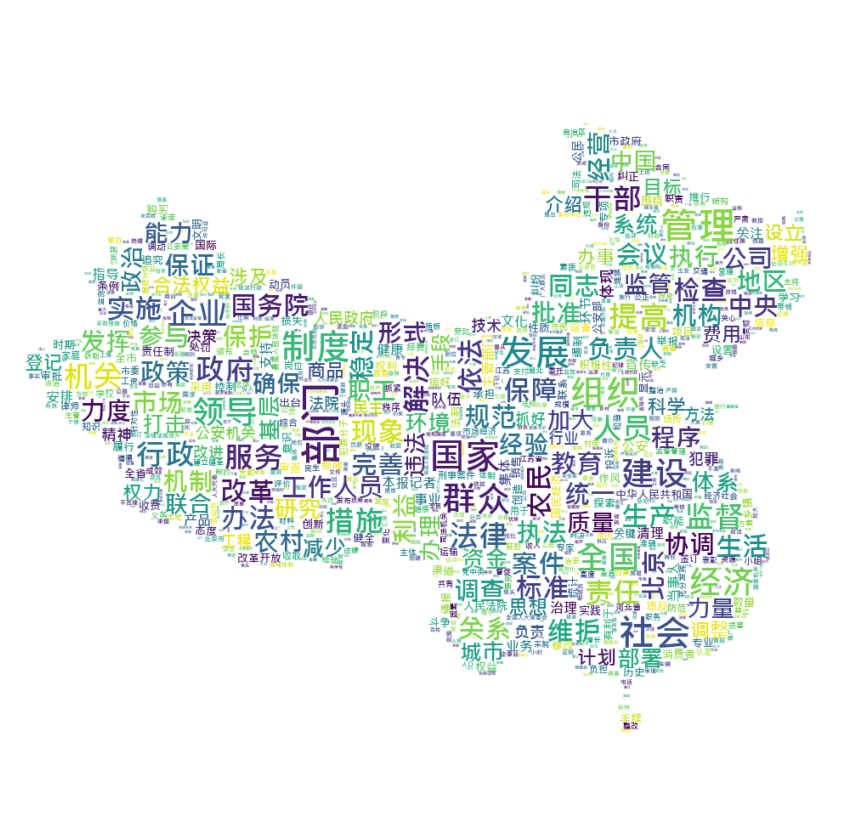

In [ ]:
words=clus_token[0]
mask='china.jpg'
title='台湾'
color='white'
path="D:/my python/people/"
people.word_cloud_map(words,title, mask,path, color='white', max_font_size=50,min_font_size=3, max_words=1000, margin=2)

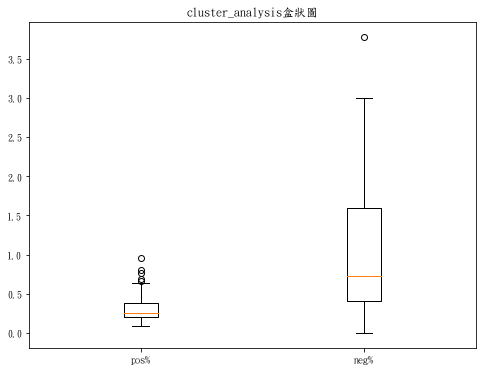

In [ ]:
df_cat = people.plot_variables_compare(df_pn, variables=['pos%','neg%'])

In [ ]:
df1

,Unnamed: 0,year,filename,title,textrank,褒獎詞,貶抑詞,反革命,pos,neg,anti,cate
0,0,1990,人民日報_19900607_2_871306,澳门基本法起草委员会举行第四次全体会议本报北京６月７日讯,起草 澳门基本法 委会 小组 专题 基本法 澳门 草委 会议 全体会议 内地 主任委员 北京...,[],[],[],0,0,0,6
1,1,1973,人民日報_19730415_1_434123,肥城矿务局坚决执行党的社会主义建设总路线,采煤 工作面 产量 提高 建设 作业 生产 煤炭 循环 工人 维修 革命干劲 机械 思想 矿...,['充分发挥'],[],[],1,0,0,9
2,2,1993,人民日報_19930606_6_939188,美朝关于核问题会谈休会双方将协商在１２日之前复会,会谈 朝鲜 美国 姜锡柱 条约 休会 核武器 协商 代表团 扩散 加卢齐 外长 让步 朝鲜政...,[],[],[],0,0,0,7
3,3,1956,人民日報_19560505_2_140308,加强果树管理全国著名苹果产地——辽宁省金县友好农业生产合作社的八百棵苹果树已经完成了喷射杀虫...,苹果 硫黄 喷射 乳剂 产地 著名 管理 全国 果树 辽宁省 杀虫 柴油 苹果树 预计 友好 增产,[],[],[],0,0,0,9
4,4,1988,人民日報_19881015_3_809940,抗生素抗果树腐烂病,果树 抗生素 防治 腐烂 轮纹病 病害 投入 特效 干腐病 很好 炭疽病 苹果 用于 批量生...,[],[],[],0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,1990,人民日報_19900427_2_867249,中朝签订一九九○年换货协议,中国 吕学俭 货物 朝鲜 李钟玉 会见 平壤 今天下午 议定书 核心 互换 万寿台 改革 开...,[],[],[],0,0,0,1
2996,2996,1987,人民日報_19870523_1_762707,我光电测距仪检测中心建成检测结果达到相应的国际水平,检测 测距仪 鉴定 数据 仪器 北京 精确 先进 委托 国家科委 性能 国际 具备 质量 评...,[],[],[],0,0,0,4
2997,2997,1986,人民日報_19860802_5_734323,教育改革要借鉴经济改革的经验,教育 改革 经济 发展 形式 学科 培养 经济体制 委托 并存 提高 生产 学校 教学 结构...,['专门人才'],"['分化', '浪费']",[],1,2,0,6
2998,2998,2004,人民日報_20040627_1_20594,东三省人才市场一体化启动,人才 市场 三省 东北地区 人事代理 统一 合作 信息 东北三省 标志 框架 长春 辽宁 吉...,[],[],[],0,0,0,6


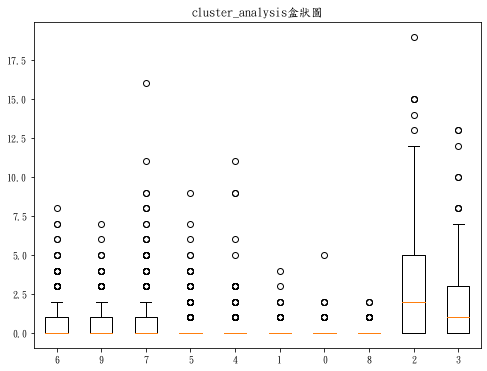

In [ ]:
df_cat = people.plot_single_variable_cate(df1, variable='neg',cate='cate')

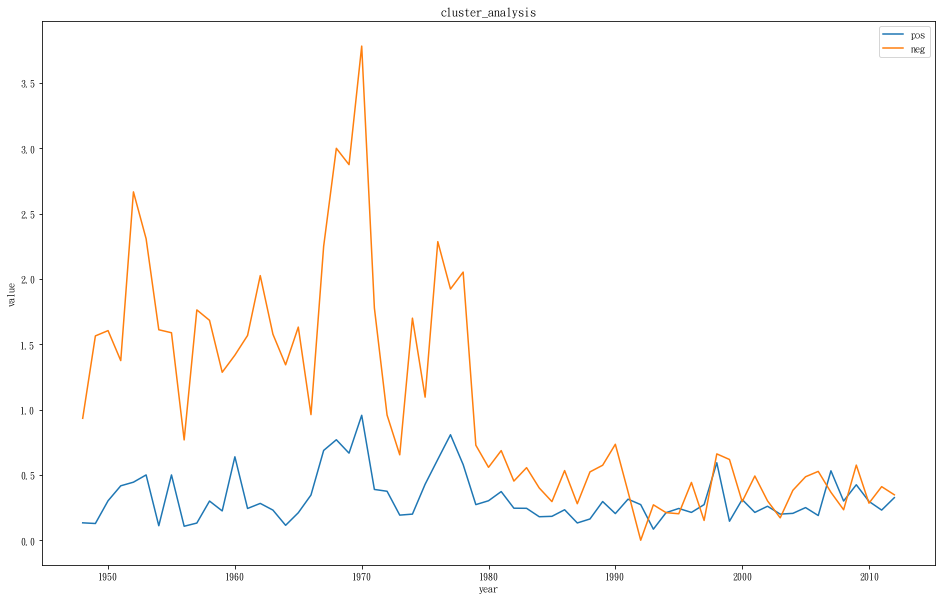

In [ ]:
df_mean = people.plot_variables_year_trend(df1, variables=['pos','neg'])

# 其他

## 讀檔

In [ ]:
pth='d:/my python/people/working/'
filename='para孔子.xlsx'
dfs=people.read_excel_file(filename,pth)
dfs

,Unnamed: 0,year,filename,title,para
0,0,1946,人民日報_19461003_2_5141,山东省府派员祭孔,孔府执事人愤恨国民党与民为敌，认为解放区各种设施与孔子“民为邦本”的精神甚相融洽。
1,1,1946,人民日報_19461003_2_5141,山东省府派员祭孔,【新华社滕县二十九日电】旧历八月二十七日（九月二十二日），为孔子诞辰，山东民主省政府特派司法...
2,2,1946,人民日報_19461025_2_5424,要求真正的停战令,保持一月十三日位置，从来是国共美三方公认的唯一停战准备，一月十日的停战令本身不必说，一月二十...
3,3,1946,人民日報_19461230_1_1562,论正统,辛亥革命以前，远至西周初年，汉民族称自己的祖国为中国（见尚书梓材篇），国家主权为汉民族所独有...
4,4,1947,人民日報_19470110_3_13501,毛泽东同志的儿童时代,毛泽东同志八岁时开始念书，一直到十三岁才离开那私塾。当时私塾里所教的经书，对于儿童是枯燥无味...
...,...,...,...,...,...
20955,20955,2003,人民日报_20031226_8_1287704,少年中国与天不老——中华古诗文经典诵读工程述评,本报记者 丁伟“少年智则国智，少年富则国富，少年强则国强，少年独立则国独立，少年自由则国自...
20956,20956,2003,人民日报_20031226_8_1287706,让美和高尚在心灵中统一,5.来，经过参与这一工程的几百万少年儿童的实践，促进了语文教育教材改革；经过这一工程的率先实...
20957,20957,2003,人民日报_20031226_15_1288800,伫立在毛泽东大街上,4.前，第一次来到“毛泽东大街”，这是一条东西走向的绿荫大道，双向四道，中间有绿色隔离带，两...
20958,20958,2003,人民日报_20031228_8_1291249,磨砺十年成一剑,张启成百岁老人钟敬文曾经感叹：我一年写几篇论文都感到很累，有些年轻人一年能出几本论著，实在太...


## 斷詞

In [ ]:
field='para'
title='para孔子'
dfs= people.jieba_token(dfs,field,path, title)
dfs

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache


token......


Loading model cost 0.447 seconds.
Prefix dict has been built successfully.


0 done;1000 done;2000 done;3000 done;4000 done;5000 done;6000 done;7000 done;8000 done;9000 done;10000 done;11000 done;12000 done;13000 done;14000 done;15000 done;16000 done;17000 done;18000 done;19000 done;20000 done;tfidf......
0 done;1000 done;2000 done;3000 done;4000 done;5000 done;6000 done;7000 done;8000 done;9000 done;10000 done;11000 done;12000 done;13000 done;14000 done;15000 done;16000 done;17000 done;18000 done;19000 done;20000 done;textrank......
0 done;1000 done;2000 done;3000 done;4000 done;5000 done;6000 done;7000 done;8000 done;9000 done;10000 done;11000 done;12000 done;13000 done;14000 done;15000 done;16000 done;17000 done;18000 done;

## 顯示檔案內容

In [ ]:
filename='人民日報_19461003_2_5141'
field=['title','token']
people.print_filename(filename, field,path)

## 存檔

In [ ]:
filename='人民日報_19461003_2_5141'
pth="D:/my python/people/working/" 
people.save_excel_file(df,filename, pth)